# Airline delays 
## Bureau of Transportation Statistics
https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236   
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

2015 - 2019

### Additional sources
This might be useful in matching station codes to airports:
1. http://dss.ucar.edu/datasets/ds353.4/inventories/station-list.html
2. https://www.world-airport-codes.com/

## Imports

In [0]:
# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# pyspark / sparksql
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
from pyspark.sql import SQLContext
from pyspark.sql.window import Window

# models
import math
import numpy as np
import pandas as pd
from multiprocessing.pool import ThreadPool
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher, Normalizer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, GBTRegressor, DecisionTreeRegressor
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder, _parallelFitTasks, TrainValidationSplitModel

sqlContext = SQLContext(sc)
team_folder = "dbfs:/mnt/mids-w261/team17"
dbutils.fs.ls(team_folder)


Out[1]: [FileInfo(path='dbfs:/mnt/mids-w261/team17/airlineFeaturesFull.parquet/', name='airlineFeaturesFull.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/airlineFeaturesFull_Tosh.parquet/', name='airlineFeaturesFull_Tosh.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/airlineFeaturesLARGE.parquet/', name='airlineFeaturesLARGE.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/airlineFeaturesSmall.parquet/', name='airlineFeaturesSmall.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/joinedFeaturesFull.parquet/', name='joinedFeaturesFull.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/joinedFeaturesFullClustered.parquet/', name='joinedFeaturesFullClustered.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/joinedFeaturesFull_Tosh.parquet/', name='joinedFeaturesFull_Tosh.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/joinedFeaturesSmall.parquet/', name='joinedFeaturesSmall.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/temp/', name='temp/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/temp_model/', name='temp_model/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/weatherFeaturesFull.parquet/', name='weatherFeaturesFull.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/weatherFeaturesFull_Tosh.parquet/', name='weatherFeaturesFull_Tosh.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/weatherFeaturesLARGE.parquet/', name='weatherFeaturesLARGE.parquet/', size=0),
 FileInfo(path='dbfs:/mnt/mids-w261/team17/weatherFeaturesSmall.parquet/', name='weatherFeaturesSmall.parquet/', size=0)]

# Weather Features

In [0]:
display(dbutils.fs.ls("dbfs:/mnt/mids-w261/datasets_final_project/weather_data"))

path name size dbfs:/mnt/mids-w261/datasets_final_project/weather_data/teamjvml1/ teamjvml1/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather-miss.parquet/ weather-miss.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet/ weather2015a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2016a.parquet/ weather2016a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2017a.parquet/ weather2017a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2018a.parquet/ weather2018a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2019a.parquet/ weather2019a.parquet/ 0

In [0]:
weather = spark.read.option("header", "true")\
                    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet")

In [0]:
weather.createOrReplaceTempView("weather")

WND - WIND  
CIG - SKY CEILING  
VIS - VISIBILITY  
TMP - TEMPERATURE  
DEW - DEW TEMP  
SLP - PRESSURE  
AA1 - AA4 - PRECIP  
AJ1 - SNOW  
GE1 - sky obs - clouds  
GF1 - sky obs

In [0]:
%sql
SELECT DATE, CALL_SIGN, WND, CIG, VIS, TMP, DEW, SLP, AA1, AA2, AA3, AA4, AJ1, GE1, GF1
FROM weather
WHERE trim(call_sign) = 'KORD' and report_type='FM-15' and length(AA2) > 1
ORDER BY DATE
LIMIT 10;

DATE CALL_SIGN WND CIG VIS TMP DEW SLP AA1 AA2 AA3 AA4 AJ1 GE1 GF1 2015-01-03T08:51:00.000+0000 KORD 130,5,N,0031,5 00762,5,M,N 002414,5,N,5 -0011,5 -0033,5 10200,5 01,0005,9,5 03,0005,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00762,1,99,9,99,9 2015-01-03T11:51:00.000+0000 KORD 130,5,N,0036,5 00152,5,M,N 004023,5,N,5 -0006,5 -0017,5 10162,5 01,0005,9,5 06,0023,9,1 24,0023,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00152,1,99,9,99,9 2015-01-03T14:51:00.000+0000 KORD 130,5,N,0036,5 00183,5,M,N 003219,5,N,5 +0006,5 -0006,5 10135,5 01,0003,9,5 03,0020,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00183,1,99,9,99,9 2015-01-03T17:51:00.000+0000 KORD 020,5,N,0021,5 00122,5,M,N 003219,5,N,5 +0006,5 +0000,5 10109,5 01,0013,9,5 06,0069,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-03T20:51:00.000+0000 KORD 350,5,N,0015,5 00122,5,M,N 004828,5,N,5 +0011,5 +0000,5 10097,5 01,0005,9,5 03,0038,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-03T23:51:00.000+0000 KORD 330,5,N,0026,5 00122,5,M,N 011265,5,N,5 +0006,5 +0000,5 10094,5 01,0000,2,5 06,0046,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T02:51:00.000+0000 KORD 010,5,N,0036,5 00122,5,M,N 006437,5,N,5 +0006,5 +0000,5 10089,5 01,0000,2,5 03,0003,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T05:51:00.000+0000 KORD 340,5,N,0026,5 00122,5,M,N 002414,5,N,5 +0006,5 +0000,5 10086,5 01,0005,9,5 06,0008,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T08:51:00.000+0000 KORD 330,5,N,0051,5 00122,5,M,N 002414,5,N,5 +0006,5 -0006,5 10073,5 01,0005,9,5 03,0005,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T11:51:00.000+0000 KORD 310,5,N,0046,5 00213,5,M,N 001207,5,N,5 +0000,5 -0011,5 10081,5 01,0008,9,5 06,0023,9,1 24,0145,9,1 0003,9,5,000250,9,9 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00213,1,99,9,99,9

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import functions as f

# parse wind fields
wind_schema = StructType([
    StructField("direction", FloatType(), False),
    StructField("dir_obs_quality", StringType(), False),
    StructField("type", StringType(), False),
    StructField("speed", FloatType(), False),
    StructField("speed_obs_quality", StringType(), False)
])

def wind(s):
    wind = s.split(',') if s else [float('nan'), None, None, float('nan'), None]
    wind[0], wind[3] = float(wind[0]), float(wind[3])
    return wind
  
# parse sky ceiling
# cavok = ceiling and visibility okay
ceiling_schema = StructType([
    StructField("height", FloatType(), False),
    StructField("obs_quality", StringType(), False),
    StructField("determination", StringType(), False),
    StructField("cavok", StringType(), False)
]) 

def sky_ceiling(s):
    sky = s.split(',') if s else [float('nan'), None, None, None]
    sky[0] = float(sky[0])
    return sky
  
# parse visibility
visibility_schema = StructType([
    StructField("visibility", FloatType(), False),
    StructField("vis_obs_quality", StringType(), False),
    StructField("variability", StringType(), False),
    StructField("var_obs_quality", StringType(), False)
]) 

def visibility(s):
    vis = s.split(',') if s else [float('nan'), None, None, None]
    vis[0] = float(vis[0])
    return vis

# just return the first measurement value as a float for [temperature, dew temp, pressure]
def first_value(s, sep=',', t=float):
    return t(s.split(sep)[0])

# precipitation
precipitation_schema = StructType([
    StructField("period", FloatType(), False),
    StructField("depth", FloatType(), False),
    StructField("condition", StringType(), False),
    StructField("precip_quality", StringType(), False)
]) 
def precipitation(s):
    precip = s.split(',') if s else [-1, -1, '-1', '-1']
    precip[0], precip[1] = float(precip[0]), float(precip[1])
    return precip
  
# snow
snow_schema = StructType([
    StructField("depth", FloatType(), False),
    StructField("condition", StringType(), False),
    StructField("snow_quality", StringType(), False),
    StructField("water_depth", StringType(), False)
]) 
def snow(s):
    snow = s.split(',')[:4] if s else [-1, '-1', '-1', -1]
    snow[0], snow[3] = float(snow[0]), float(snow[3])
    return snow

wind_udf = udf(wind, wind_schema)
sky_udf = udf(sky_ceiling, ceiling_schema)
vis_udf = udf(visibility, visibility_schema)
precip_udf = udf(precipitation, precipitation_schema)
snow_udf = udf(snow, snow_schema)
first_value_udf = udf(first_value, FloatType())

In [0]:
base_columns = ['station', 'date', 'latitude', 'longitude', 'elevation', 'call_sign', 
                'wnd', 'cig', 'vis', 'tmp', 'dew', 'slp', 'aa1', 'aa2', 'aa3', 'aa4', 'aj1', 'ge1', 'gf1']

In [0]:
def parse_weather_columns(weather, base_columns):
  weather = weather.filter("report_type='FM-15' and substr(trim(call_sign), 1, 1)='K'")\
    .select(base_columns)\
    .withColumn("wind_parsed", wind_udf("WND"))\
    .withColumn("sky_ceiling_parsed", sky_udf("CIG"))\
    .withColumn("visibility_parsed", vis_udf("VIS"))\
    .withColumn("snow_parsed", snow_udf("aj1"))

  for c, name in [('TMP', 'temperature'), ('DEW', 'dew_temperature'), ('SLP', 'pressure')]:
    weather = weather.withColumn(name, first_value_udf(c))

  for c in ['AA1', 'AA2', 'AA3', 'AA4']:
    weather = weather.withColumn(c+'_parsed', precip_udf(c))
  return weather

weather = parse_weather_columns(weather, base_columns)

In [0]:
weather.createOrReplaceTempView("weather")

In [0]:
%sql
SELECT sky_ceiling_parsed.height, count(1)
FROM weather
GROUP BY sky_ceiling_parsed.height
ORDER BY count(1) desc

height count(1) 22000.0 19629396 99999.0 962319 61.0 368824 1829.0 364309 91.0 325373 3353.0 323813 1524.0 320919 152.0 320306 183.0 315179 3048.0 298311 122.0 297251 2134.0 294948 213.0 288255 244.0 284127 2743.0 253587 305.0 241451 274.0 234619 2438.0 228002 366.0 212684 1981.0 207396 427.0 206903 396.0 199614 30.0 196522 1676.0 193008 3658.0 191931 335.0 191808 457.0 190559 488.0 178741 2286.0 176502 518.0 165889 549.0 161957 610.0 157264 579.0 156776 640.0 144388 671.0 140731 701.0 134649 762.0 131961 732.0 131959 2591.0 129508 792.0 126322 914.0 123403 853.0 122566 823.0 121302 884.0 115327 2896.0 114032 7620.0 113323 1067.0 109945 1036.0 106875 975.0 106510 1006.0 105303 1097.0 101056 1463.0 99985 945.0 97323 1128.0 94859 1219.0 94287 1158.0 92970 1402.0 88473 1189.0 87073 1280.0 86301 1250.0 82820 1341.0 82519 1311.0 78122 1372.0 75968 1433.0 72874 1494.0 71823 6096.0 43082 4572.0 30894 5486.0 16449 4267.0 15218 3962.0 13804 6706.0 13039 4877.0 10768 9144.0 8170 5182.0 8159 7010.0 6132 5791.0 5798 6401.0 5294 7315.0 5075 0.0 4749 8534.0 3530 7925.0 3260 8230.0 1406 8839.0 242 10668.0 154 9449.0 85 9754.0 83 10058.0 52 1707.0 27 1554.0 21 1585.0 18 10363.0 14 1615.0 12 1768.0 10 3505.0 7 3810.0 7 4115.0 6 1646.0 6 1951.0 5 2.0 5 4.0 5 2225.0 5 2469.0 4 2073.0 4 2256.0 4 2316.0 4 2621.0 3 1859.0 3 9.0 3 5029.0 3 3.0 3 4846.0 3 1920.0 3 2195.0 3 1890.0 2 11278.0 2 4542.0 2 4724.0 2 6980.0 2 1737.0 2 3200.0 2 5425.0 2 11582.0 2 3292.0 2 2012.0 2 2347.0 2 6553.0 2 5822.0 2 3018.0 1 2408.0 1 3627.0 1 6858.0 1 5944.0 1 6.0 1 8809.0 1 3536.0 1 4206.0 1 13.0 1 12832.0 1 3749.0 1 3475.0 1 3566.0 1 11.0 1 2804.0 1 11887.0 1 4694.0 1 15240.0 1 3932.0 1 7.0 1 12.0 1 2560.0 1 7894.0 1 5121.0 1 2682.0 1 2713.0 1 2377.0 1 2530.0 1 5.0 1 4755.0 1 3261.0 1 7681.0 1 6949.0 1

In [0]:
%sql
-- example of lag window function
SELECT *
FROM (
SELECT 
  --date_trunc('HOUR', DATE) + INTERVAL 2 hours as join_datetime,
  date,
  trim(call_sign) as call_sign,
    
  -- wind
  wind_parsed,
  wind_parsed.speed as wind_speed, 
  wind_parsed.speed - lag(wind_parsed.speed, 1) over (partition by call_sign order by date) as wind_speed_minus_1,
  wind_parsed.speed - lag(wind_parsed.speed, 2) over (partition by call_sign order by date) as wind_speed_minus_2,
  wind_parsed.speed - max(wind_parsed.speed) over (partition by call_sign order by date rows 2 preceding) as diff_to_max_wind
FROM weather
WHERE trim(call_sign) in ('KATL', 'KORD')
ORDER BY call_sign, date
LIMIT 10) WHERE wind_speed_minus_2 is not null and wind_speed != 0;

date call_sign wind_parsed wind_speed wind_speed_minus_1 wind_speed_minus_2 diff_to_max_wind 2015-01-01T03:52:00.000+0000 KATL List(320.0, 5, N, 26.0, 5) 26.0 26.0 5.0 0.0 2015-01-01T04:52:00.000+0000 KATL List(320.0, 5, N, 31.0, 5) 31.0 5.0 31.0 0.0 2015-01-01T05:52:00.000+0000 KATL List(330.0, 5, N, 21.0, 5) 21.0 -10.0 -5.0 -10.0 2015-01-01T06:52:00.000+0000 KATL List(320.0, 5, N, 31.0, 5) 31.0 10.0 0.0 0.0 2015-01-01T07:52:00.000+0000 KATL List(330.0, 5, N, 26.0, 5) 26.0 -5.0 5.0 -5.0 2015-01-01T09:52:00.000+0000 KATL List(330.0, 5, N, 36.0, 5) 36.0 36.0 10.0 0.0

In [0]:
def create_weather_features(weather_parsed, where_clause=""):
  weather_parsed.createOrReplaceTempView("weather_parsed")
  weatherFeatures = spark.sql("""
    SELECT 
      date_trunc('HOUR', DATE) + INTERVAL 2 hours as join_datetime,
      date,
      trim(call_sign) as call_sign,

      -- wind
      wind_parsed.speed as wind_speed, 
      wind_parsed.speed - lag(wind_parsed.speed, 1) over (partition by call_sign order by date) as wind_speed_minus_1,
      wind_parsed.speed - lag(wind_parsed.speed, 2) over (partition by call_sign order by date) as wind_speed_minus_2,
      wind_parsed.speed - max(wind_parsed.speed) over (partition by call_sign order by date rows 2 preceding) as diff_to_max_wind,

      -- visibility
      visibility_parsed.visibility as visibility, 
      visibility_parsed.visibility - lag(visibility_parsed.visibility, 1) over (partition by call_sign order by date) as visibility_minus_1,
      visibility_parsed.visibility - lag(visibility_parsed.visibility, 2) over (partition by call_sign order by date) as visibility_minus_2,
      visibility_parsed.variability as visibility_variability,

      -- sky_ceiling
      sky_ceiling_parsed.height as ceiling, 
      sky_ceiling_parsed.height - lag(sky_ceiling_parsed.height, 1) over (partition by call_sign order by date) as ceiling_minus_1,
      sky_ceiling_parsed.height - lag(sky_ceiling_parsed.height, 2) over (partition by call_sign order by date) as ceiling_minus_2,
      sky_ceiling_parsed.cavok,

      -- snow
      snow_parsed.condition as snow_condition,
      snow_parsed.depth as snow_depth, 
      snow_parsed.depth - lag(snow_parsed.depth, 1) over (partition by call_sign order by date) as snow_depth_minus_1,
      snow_parsed.depth - lag(snow_parsed.depth, 2) over (partition by call_sign order by date) as snow_depth_minus_2,

      -- precipitation
      aa1_parsed.period as precip_period,
      aa1_parsed.depth as precip_depth,
      case when aa4_parsed.depth > 0 then aa4_parsed.depth
           when aa3_parsed.depth > 0 then aa3_parsed.depth
           when aa2_parsed.depth > 0 then aa2_parsed.depth
           else aa1_parsed.depth end as max_precip_depth,
      case when aa4_parsed.depth > 0 then aa4_parsed.period
           when aa3_parsed.depth > 0 then aa3_parsed.period
           when aa2_parsed.depth > 0 then aa2_parsed.period
           else aa1_parsed.period end as max_precip_period,

      -- pressure
      pressure,
      pressure - lag(pressure, 1) over (partition by call_sign order by date) as pressure_minus_1,
      pressure - lag(pressure, 2) over (partition by call_sign order by date) as pressure_minus_2,

      temperature,
      dew_temperature,
      latitude, 
      longitude, 
      elevation

    FROM weather_parsed
    {where_clause}
    ORDER BY call_sign, date;
    """.format(where_clause=where_clause))
  return weatherFeatures

In [0]:
weather_features = create_weather_features(weather, "WHERE trim(call_sign) in ('KATL', 'KORD')")
display(weather_features)

join_datetime date call_sign wind_speed wind_speed_minus_1 wind_speed_minus_2 diff_to_max_wind visibility visibility_minus_1 visibility_minus_2 visibility_variability ceiling ceiling_minus_1 ceiling_minus_2 cavok snow_condition snow_depth snow_depth_minus_1 snow_depth_minus_2 precip_period precip_depth max_precip_depth max_precip_period pressure pressure_minus_1 pressure_minus_2 temperature dew_temperature latitude longitude elevation 2015-01-01T02:00:00.000+0000 2015-01-01T00:52:00.000+0000 KATL 26.0 null null 0.0 16093.0 null null N 22000.0 null null N -1 -1.0 null null 1.0 0.0 0.0 1.0 10289.0 null null 50.0 6.0 33.6301 -84.4418 307.8 2015-01-01T03:00:00.000+0000 2015-01-01T01:52:00.000+0000 KATL 21.0 -5.0 null -5.0 16093.0 0.0 null N 22000.0 0.0 null N -1 -1.0 0.0 null 1.0 0.0 0.0 1.0 10290.0 1.0 null 44.0 0.0 33.6301 -84.4418 307.8 2015-01-01T04:00:00.000+0000 2015-01-01T02:52:00.000+0000 KATL 0.0 -21.0 -26.0 -26.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10285.0 -5.0 -4.0 44.0 0.0 33.6301 -84.4418 307.8 2015-01-01T05:00:00.000+0000 2015-01-01T03:52:00.000+0000 KATL 26.0 26.0 5.0 0.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10289.0 4.0 -1.0 33.0 -6.0 33.6301 -84.4418 307.8 2015-01-01T06:00:00.000+0000 2015-01-01T04:52:00.000+0000 KATL 31.0 5.0 31.0 0.0 16093.0 0.0 0.0 N 6096.0 -15904.0 -15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10283.0 -6.0 -2.0 28.0 -11.0 33.6301 -84.4418 307.8 2015-01-01T07:00:00.000+0000 2015-01-01T05:52:00.000+0000 KATL 21.0 -10.0 -5.0 -10.0 16093.0 0.0 0.0 N 6096.0 0.0 -15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 -3.0 -9.0 28.0 -17.0 33.6301 -84.4418 307.8 2015-01-01T08:00:00.000+0000 2015-01-01T06:52:00.000+0000 KATL 31.0 10.0 0.0 0.0 16093.0 0.0 0.0 N 22000.0 15904.0 15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10281.0 1.0 -2.0 22.0 -17.0 33.6301 -84.4418 307.8 2015-01-01T09:00:00.000+0000 2015-01-01T07:52:00.000+0000 KATL 26.0 -5.0 5.0 -5.0 16093.0 0.0 0.0 N 22000.0 0.0 15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 -1.0 0.0 17.0 -22.0 33.6301 -84.4418 307.8 2015-01-01T10:00:00.000+0000 2015-01-01T08:52:00.000+0000 KATL 0.0 -26.0 -31.0 -31.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10274.0 -6.0 -7.0 17.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T11:00:00.000+0000 2015-01-01T09:52:00.000+0000 KATL 36.0 36.0 10.0 0.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10270.0 -4.0 -10.0 11.0 -28.0 33.6301 -84.4418 307.8 2015-01-01T12:00:00.000+0000 2015-01-01T10:52:00.000+0000 KATL 15.0 -21.0 15.0 -21.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10268.0 -2.0 -6.0 6.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T13:00:00.000+0000 2015-01-01T11:52:00.000+0000 KATL 31.0 16.0 -5.0 -5.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10276.0 8.0 6.0 0.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T14:00:00.000+0000 2015-01-01T12:52:00.000+0000 KATL 0.0 -31.0 -15.0 -31.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 4.0 12.0 0.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T15:00:00.000+0000 2015-01-01T13:52:00.000+0000 KATL 0.0 0.0 -31.0 -31.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10276.0 -4.0 0.0 28.0 -22.0 33.6301 -84.4418 307.8 2015-01-01T16:00:00.000+0000 2015-01-01T14:52:00.000+0000 KATL 0.0 0.0 0.0 0.0 16093.0 0.0 0.0 N 7620.0 -14380.0 -14380.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 4.0 0.0 61.0 -28.0 33.6301 -84.4418 307.8 2015-01-01T17:00:00.000+0000 2015-01-01T15:52:00.000+0000 KATL 21.0 21.0 21.0 0.0 16093.0 0.0 0.0 N 7010.0 -610.0 -14990.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10285.0 5.0 9.0 83.0 -28.0 33.6301 -84.4418 307.8 2015-01-01T18:00:00.000+0000 2015-01-01T16:52:00.000+0000 KATL 15.0 -6.0 15.0 -6.0 16093.0 0.0 0.0 N 7010.0 0.0 -610.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10270.0 -15.0 -10.0 100.0 -61.0 33.6301 -84.4418 307.8 2015-01-01T19:00:00.000+0000 2015-01-01T17:52:00.000+0000 KATL 15.0 0.0 -6.0 -6.

for every hour  
current weather  
weather for each of the past 3 hours  
summary of the past 3 hours

### Write Intermediate
Small dataset on 2015 data

In [0]:
weather_features \
.write \
.mode('Overwrite') \
.parquet(team_folder + "/weatherFeaturesSmall.parquet")

Full dataset 2015-2019

In [0]:
full_weather = spark.read.option("header", "true")\
                    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather201*a.parquet")
full_weather_parsed = parse_weather_columns(full_weather, base_columns)
full_weather_features = create_weather_features(full_weather_parsed, where_clause="")

In [0]:
full_weather_features \
.write \
.mode('Overwrite') \
.parquet(team_folder + "/weatherFeaturesFull.parquet")

# Airline Features

In [0]:
interesting_columns_airlines = ['FL_DATE', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST',
                              'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP',
                              'DEP_DELAY', 'DEP_DEL15', 
                              'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*.parquet")

display(airlines.sample(False, 0.0001))

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2019 3 7 7 7 2019-07-07 WN 19393 WN N948WN 3313 11278 1127805 30852 DCA Washington, DC VA 51 Virginia 38 13198 1319801 33198 MCI Kansas City, MO MO 29 Missouri 64 1635 1711 36.0 36.0 1.0 2 1600-1659 7.0 1718 1830 5.0 1815 1835 20.0 20.0 1.0 1 1800-1859 0.0 null 0.0 160.0 144.0 132.0 1.0 949.0 4 8.0 0.0 0.0 0.0 12.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 7 7 2019-07-07 WN 19393 WN N8671D 4802 11292 1129202 30325 DEN Denver, CO CO 8 Colorado 82 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 625 626 1.0 1.0 0.0 0 0600-0659 10.0 636 1144 7.0 1200 1151 -9.0 0.0 0.0 -1 1200-1259 0.0 null 0.0 215.0 205.0 188.0 1.0 1546.0 7 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 29 1 2019-07-29 B6 20409 B6 N537JT 719 12478 1247805 31703 JFK New York, NY NY 36 New York 22 10397 1039707 30397 ATL Atlanta, GA GA 13 Georgia 34 1458 1454 -4.0 0.0 0.0 -1 1400-1459 17.0 1511 1649 7.0 1749 1656 -53.0 0.0 0.0 -2 1700-1759 0.0 null 0.0 171.0 122.0 98.0 1.0 760.0 4 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 15 1 2019-07-15 WN 19393 WN N8302F 2549 12889 1288903 32211 LAS Las Vegas, NV NV 32 Nevada 85 14747 1474703 30559 SEA Seattle, WA WA 53 Washington 93 1300 1308 8.0 8.0 0.0 0 1300-1359 14.0 1322 1525 7.0 1540 1532 -8.0 0.0 0.0 -1 1500-1559 0.0 null 0.0 160.0 144.0 123.0 1.0 867.0 4 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 27 6 2019-07-27 WN 19393 WN N8669B 2922 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 10397 1039707 30397 ATL Atlanta, GA GA 13 Georgia 34 1735 1732 -3.0 0.0 0.0 -1 1700-1759 24.0 1756 185

In [0]:
def select_columns_and_format_time(airlines, select_columns, filters=[]):
  # fl_date between '2015-01-01' and '2015-03-31' 
  for condition in filters:
    airlines = airlines.filter(condition)
  # select specified columns
  airlines = airlines.select(select_columns).distinct()
  
  airlines = airlines.withColumn("CRS_DEP_TIME", f.format_string('%04d', f.col("CRS_DEP_TIME")).cast("String"))
  airlines = airlines \
    .withColumn("scheduled_flight_datetime", f.concat(f.col("fl_date") ,f.col("CRS_DEP_TIME"))) \
    .withColumn("scheduled_flight_datetime", f.to_timestamp(f.col("scheduled_flight_datetime"), "yyyy-MM-ddHHmm")) \
    .withColumn("local_hour", f.hour(f.col("scheduled_flight_datetime")))
  
  # make id numbers strings since they are categorical values
  cat_columns = ['op_carrier_fl_num']
  for c in [c for c in cat_columns if c in select_columns]:
    airlines = airlines.withColumn(c, f.col(c).cast(StringType()))
  
  return airlines

In [0]:
airlines_time_formatted = select_columns_and_format_time(airlines, interesting_columns_airlines, filters=["""fl_date between '2015-01-01' and '2015-03-31'"""])
display(airlines_time_formatted)

FL_DATE QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime hour 2015-03-23 1 3 23 1 MIA BOS AA N3FJAA 146 2100 182.0 6 0.0 0.0 null null null null null 2015-03-23T21:00:00.000+0000 21 2015-03-07 1 3 7 6 BWI DFW AA N472AA 150 1601 219.0 5 14.0 0.0 0.0 0.0 3.0 0.0 14.0 2015-03-07T16:01:00.000+0000 16 2015-03-13 1 3 13 5 DFW BWI AA N555AA 150 1135 162.0 5 -5.0 0.0 null null null null null 2015-03-13T11:35:00.000+0000 11 2015-03-23 1 3 23 1 DFW SJC AA N475AA 189 1250 232.0 6 73.0 1.0 73.0 0.0 8.0 0.0 0.0 2015-03-23T12:50:00.000+0000 12 2015-03-02 1 3 2 1 DFW ATL AA N018AA 194 1130 116.0 3 11.0 0.0 null null null null null 2015-03-02T11:30:00.000+0000 11 2015-03-01 1 3 1 7 ORD SFO AA N3ESAA 197 1355 282.0 8 37.0 1.0 14.0 0.0 15.0 0.0 23.0 2015-03-01T13:55:00.000+0000 13 2015-03-12 1 3 12 4 LAX BOS AA N3LPAA 202 1300 327.0 11 1.0 0.0 null null null null null 2015-03-12T13:00:00.000+0000 13 2015-03-29 1 3 29 7 BOS LAX AA N3LTAA 205 0700 392.0 11 -4.0 0.0 null null null null null 2015-03-29T07:00:00.000+0000 7 2015-03-09 1 3 9 1 JFK LAX AA N795AA 181 1735 400.0 10 0.0 0.0 null null null null null 2015-03-09T17:35:00.000+0000 17 2015-03-29 1 3 29 7 ORD BOS AA N3KLAA 186 1150 143.0 4 -4.0 0.0 null null null null null 2015-03-29T11:50:00.000+0000 11 2015-03-25 1 3 25 3 SFO DFW AA N3JMAA 259 1320 205.0 6 -3.0 0.0 null null null null null 2015-03-25T13:20:00.000+0000 13 2015-03-05 1 3 5 4 MIA DFW AA N3DWAA 281 0600 200.0 5 null null null null null null null 2015-03-05T06:00:00.000+0000 6 2015-03-03 1 3 3 2 MIA LAX AA N861AA 287 1405 358.0 10 -3.0 0.0 null null null null null 2015-03-03T14:05:00.000+0000 14 2015-03-21 1 3 21 6 JFK AUS AA N3HUAA 291 1700 265.0 7 43.0 1.0 14.0 0.0 0.0 0.0 9.0 2015-03-21T17:00:00.000+0000 17 2015-03-12 1 3 12 4 ATL DFW AA N017AA 356 1644 151.0 3 -6.0 0.0 null null null null null 2015-03-12T16:44:00.000+0000 16 2015-03-22 1 3 22 7 DFW DEN AA N501AA 313 1020 126.0 3 3.0 0.0 null null null null null 2015-03-22T10:20:00.000+0000 10 2015-03-03 1 3 3 2 DFW MCO AA N3HFAA 324 1055 140.0 4 -1.0 0.0 null null null null null 2015-03-03T10:55:00.000+0000 10 2015-03-03 1 3 3 2 DFW JAX AA N599AA 386 1430 131.0 4 24.0 1.0 24.0 0.0 1.0 0.0 0.0 2015-03-03T14:30:00.000+0000 14 2015-03-17 1 3 17 2 DFW PNS AA N503AA 901 1325 108.0 3 49.0 1.0 1.0 0.0 0.0 0.0 41.0 2015-03-17T13:25:00.000+0000 13 2015-03-28 1 3 28 6 PNS DFW AA N4XJAA 902 0708 126.0 3 null null null null null null null 2015-03-28T07:08:00.000+0000 7 2015-03-12 1 3 12 4 ORD DFW AA N4YUAA 2321 1135 150.0 4 55.0 1.0 43.0 0.0 0.0 0.0 0.0 2015-03-12T11:35:00.000+0000 11 2015-03-31 1 3 31 2 MIA LGA AA N3BUAA 2325 2050 176.0 5 41.0 1.0 0.0 0.0 0.0 0.0 25.0 2015-03-31T20:50:00.000+0000 20 2015-03-31 1 3 31 2 DFW COS AA N4YAAA 2330 0900 123.0 3 -5.0 0.0 null null null null null 2015-03-31T09:00:00.000+0000 9 2015-03-30 1 3 30 1 ORD DFW AA N3ADAA 2331 1410 157.0 4 -2.0 0.0 null null null null null 2015-03-30T14:10:00.000+0000 14 2015-03-27 1 3 27 5 DFW ORD AA N017AA 2332 0740 135.0 4 -7.0 0.0 null null null null null 2015-03-27T07:40:00.000+0000 7 2015-03-13 1 3 13 5 IND DFW AA N479AA 2337 0703 157.0 4 -3.0 0.0 null null null null null 2015-03-13T07:03:00.000+0000 7 2015-03-29 1 3 29 7 MIA EWR AA N3ABAA 2338 2105 181.0 5 21.0 1.0 21.0 0.0 10.0 0.0 0.0 2015-03-29T21:05:00.000+0000 21 2015-03-06 1 3 6 5 DCA ORD AA N3JPAA 2340 1855 131.0 3 24.0 1.0 null null null null null 2015-03-06T18:55:00.000+0000 18 2015-03-30 1 3 30 1 DCA ORD AA N3DPAA 2340 1818 137.0 3 -5.0 0.0 null null null null null 2015-03-30T18:18:00.000+0000 18 2015-03-13 1 3 13 5 DFW ORD AA N3JUAA 2343 2050 122.0 4 -4.0 0.0 null null null null null 2015-03-13T20:50:00.000+0000 20 2015-03-01 1 3 1 7 LAX SFO AA N3LCAA 2378 1030 83.0 2 5.0 0.0 null null null null null 2015-03-01T10:30:00.000+0000 10 2015-03-20 1 3

In [0]:
def adjust_flight_times_to_utc(airlines_time_formatted, tz_data="dbfs:/FileStore/tables/timezones-1.csv"):
  tz = spark.read.option("header", "true").csv(tz_data)
  airlines_with_tz = airlines_time_formatted.join(f.broadcast(tz), airlines_time_formatted.ORIGIN == tz.iata_code)
  airlines_with_tz = airlines_with_tz.drop("iata_code", "windows_tz")
  airlines_with_tz = airlines_with_tz \
    .withColumn("scheduled_flight_datetime_UTC", 
                f.to_utc_timestamp(f.col("scheduled_flight_datetime"), f.col("iana_tz"))).filter("DEP_DELAY is not null") \
    .withColumn("scheduled_flight_hour_UTC", 
                f.date_trunc('hour', f.col("scheduled_flight_datetime_UTC")))
  return airlines_with_tz

In [0]:
tz = spark.read.option("header", "true").csv(f"dbfs:/FileStore/tables/timezones-1.csv")
display(tz)

iata_code iana_tz windows_tz AAA Pacific/Tahiti Hawaiian Standard Time AAB Australia/Brisbane E. Australia Standard Time AAC Africa/Cairo Egypt Standard Time AAD Africa/Mogadishu E. Africa Standard Time AAE Africa/Algiers W. Central Africa Standard Time AAF America/New_York Eastern Standard Time AAG America/Sao_Paulo E. South America Standard Time AAH Europe/Berlin W. Europe Standard Time AAI America/Araguaina Tocantins Standard Time AAJ America/Paramaribo SA Eastern Standard Time AAK Pacific/Tarawa UTC+12 AAL Europe/Copenhagen Romance Standard Time AAM Africa/Johannesburg South Africa Standard Time AAN Asia/Dubai Arabian Standard Time AAO America/Caracas Venezuela Standard Time AAQ Europe/Moscow Russian Standard Time AAR Europe/Copenhagen Romance Standard Time AAS Asia/Jayapura Tokyo Standard Time AAT Asia/Shanghai China Standard Time AAU Pacific/Apia Samoa Standard Time AAV Asia/Manila Singapore Standard Time AAX America/Sao_Paulo E. South America Standard Time AAY Asia/Aden Arab Standard Time AAZ America/Guatemala Central America Standard Time ABA Asia/Krasnoyarsk North Asia Standard Time ABB Africa/Lagos W. Central Africa Standard Time ABC Europe/Madrid Romance Standard Time ABD Asia/Tehran Iran Standard Time ABE America/New_York Eastern Standard Time ABF Pacific/Tarawa UTC+12 ABG Australia/Brisbane E. Australia Standard Time ABH Australia/Brisbane E. Australia Standard Time ABI America/Chicago Central Standard Time ABJ Africa/Abidjan Greenwich Standard Time ABK Africa/Addis_Ababa E. Africa Standard Time ABL America/Anchorage Alaskan Standard Time ABM Australia/Brisbane E. Australia Standard Time ABN America/Cayenne SA Eastern Standard Time ABO Africa/Abidjan Greenwich Standard Time ABP Pacific/Port_Moresby West Pacific Standard Time ABQ America/Denver Mountain Standard Time ABR America/Chicago Central Standard Time ABS Africa/Cairo Egypt Standard Time ABT Asia/Riyadh Arab Standard Time ABU Asia/Makassar Singapore Standard Time ABV Africa/Lagos W. Central Africa Standard Time ABX Australia/Melbourne AUS Eastern Standard Time ABY America/New_York Eastern Standard Time ABZ Europe/London GMT Standard Time ACA America/Mexico_City Central Standard Time (Mexico) ACB America/Detroit Eastern Standard Time ACC Africa/Accra Greenwich Standard Time ACD America/Bogota SA Pacific Standard Time ACE Atlantic/Canary GMT Standard Time ACF Australia/Brisbane E. Australia Standard Time ACH Europe/Vienna W. Europe Standard Time ACI Europe/Guernsey GMT Standard Time ACJ Asia/Colombo Sri Lanka Standard Time ACK America/New_York Eastern Standard Time ACL America/Bogota SA Pacific Standard Time ACM America/Bogota SA Pacific Standard Time ACN America/Matamoros Central Standard Time ACP Asia/Tehran Iran Standard Time ACR America/Bogota SA Pacific Standard Time ACS Asia/Krasnoyarsk North Asia Standard Time ACT America/Chicago Central Standard Time ACU America/Panama SA Pacific Standard Time ACV America/Los_Angeles Pacific Standard Time ACX Asia/Shanghai China Standard Time ACY America/New_York Eastern Standard Time ACZ Asia/Tehran Iran Standard Time ADA Europe/Istanbul Turkey Standard Time ADB Europe/Istanbul Turkey Standard Time ADC Pacific/Port_Moresby West Pacific Standard Time ADD Africa/Addis_Ababa E. Africa Standard Time ADE Asia/Aden Arab Standard Time ADF Europe/Istanbul Turkey Standard Time ADG America/Detroit Eastern Standard Time ADH Asia/Yakutsk Yakutsk Standard Time ADI Africa/Windhoek Namibia Standard Time ADJ Asia/Amman Jordan Standard Time ADK America/Adak Aleutian Standard Time ADL Australia/Adelaide Cen. Australia Standard Time ADM America/Chicago Central Standard Time ADN America/Bogota SA Pacific Standard Time ADO Australia/Adelaide Cen. Australia Standard Time ADP Asia/Colombo Sri Lanka Standard Time ADQ America/Anchorage Alaskan Standard Time ADR America/New_York Eastern Standard Time ADS America/Chicago Central Standard Time ADT America/Chicago Central Standard Time ADU Asia/Tehran Iran Standard Time ADV Africa/Khartoum Sudan 

In [0]:
airlines_with_tz = adjust_flight_times_to_utc(airlines_time_formatted, tz_data="dbfs:/FileStore/tables/timezones-1.csv")
display(airlines_with_tz)

FL_DATE QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime hour iana_tz scheduled_flight_datetime_UTC scheduled_flight_hour_UTC 2015-02-05 1 2 5 4 DFW MCO AA N3HPAA 324 1110 142.0 4 -3.0 0.0 null null null null null 2015-02-05T11:10:00.000+0000 11 America/Chicago 2015-02-05T17:10:00.000+0000 2015-02-05T17:00:00.000+0000 2015-02-05 1 2 5 4 DFW DCA AA N3DEAA 926 1800 161.0 5 68.0 1.0 0.0 0.0 5.0 0.0 68.0 2015-02-05T18:00:00.000+0000 18 America/Chicago 2015-02-06T00:00:00.000+0000 2015-02-06T00:00:00.000+0000 2015-02-21 1 2 21 6 DFW TPA AA N403AA 942 1710 136.0 4 -2.0 0.0 null null null null null 2015-02-21T17:10:00.000+0000 17 America/Chicago 2015-02-21T23:10:00.000+0000 2015-02-21T23:00:00.000+0000 2015-02-22 1 2 22 7 MSY DFW AA N483AA 975 1448 102.0 2 -11.0 0.0 null null null null null 2015-02-22T14:48:00.000+0000 14 America/Chicago 2015-02-22T20:48:00.000+0000 2015-02-22T20:00:00.000+0000 2015-02-06 1 2 6 5 IAH DFW AA N4WTAA 976 1331 73.0 1 -7.0 0.0 null null null null null 2015-02-06T13:31:00.000+0000 13 America/Chicago 2015-02-06T19:31:00.000+0000 2015-02-06T19:00:00.000+0000 2015-02-14 1 2 14 6 ORD MIA AA N3LFAA 1078 0600 183.0 5 25.0 1.0 8.0 7.0 0.0 0.0 0.0 2015-02-14T06:00:00.000+0000 6 America/Chicago 2015-02-14T12:00:00.000+0000 2015-02-14T12:00:00.000+0000 2015-02-24 1 2 24 2 DFW IAH AA N3MEAA 351 1510 65.0 1 -3.0 0.0 null null null null null 2015-02-24T15:10:00.000+0000 15 America/Chicago 2015-02-24T21:10:00.000+0000 2015-02-24T21:00:00.000+0000 2015-02-16 1 2 16 1 IAH DFW AA N3EGAA 351 1710 73.0 1 -8.0 0.0 null null null null null 2015-02-16T17:10:00.000+0000 17 America/Chicago 2015-02-16T23:10:00.000+0000 2015-02-16T23:00:00.000+0000 2015-02-22 1 2 22 7 ORD LGA AA N3DPAA 354 1635 123.0 3 -3.0 0.0 null null null null null 2015-02-22T16:35:00.000+0000 16 America/Chicago 2015-02-22T22:35:00.000+0000 2015-02-22T22:00:00.000+0000 2015-02-14 1 2 14 6 TUL DFW AA N595AA 1035 1800 75.0 1 -10.0 0.0 null null null null null 2015-02-14T18:00:00.000+0000 18 America/Chicago 2015-02-15T00:00:00.000+0000 2015-02-15T00:00:00.000+0000 2015-02-25 1 2 25 3 ORD SEA AA N3GBAA 1054 1110 277.0 7 -3.0 0.0 null null null null null 2015-02-25T11:10:00.000+0000 11 America/Chicago 2015-02-25T17:10:00.000+0000 2015-02-25T17:00:00.000+0000 2015-02-13 1 2 13 5 LAX ORD AA N3ELAA 1067 0715 243.0 7 -5.0 0.0 null null null null null 2015-02-13T07:15:00.000+0000 7 America/Los_Angeles 2015-02-13T15:15:00.000+0000 2015-02-13T15:00:00.000+0000 2015-02-07 1 2 7 6 SEA MIA AA N3JCAA 1070 2355 331.0 11 0.0 0.0 null null null null null 2015-02-07T23:55:00.000+0000 23 America/Los_Angeles 2015-02-08T07:55:00.000+0000 2015-02-08T07:00:00.000+0000 2015-02-11 1 2 11 3 SEA MIA AA N3CVAA 1070 2355 331.0 11 -4.0 0.0 null null null null null 2015-02-11T23:55:00.000+0000 23 America/Los_Angeles 2015-02-12T07:55:00.000+0000 2015-02-12T07:00:00.000+0000 2015-02-23 1 2 23 1 DFW TPA AA N4XBAA 1072 2040 133.0 4 -2.0 0.0 0.0 0.0 15.0 0.0 0.0 2015-02-23T20:40:00.000+0000 20 America/Chicago 2015-02-24T02:40:00.000+0000 2015-02-24T02:00:00.000+0000 2015-02-17 1 2 17 2 MIA IAD AA N3HNAA 1137 1400 150.0 4 -1.0 0.0 null null null null null 2015-02-17T14:00:00.000+0000 14 America/New_York 2015-02-17T19:00:00.000+0000 2015-02-17T19:00:00.000+0000 2015-02-05 1 2 5 4 DFW TUS AA N548AA 1001 1830 144.0 4 -4.0 0.0 null null null null null 2015-02-05T18:30:00.000+0000 18 America/Chicago 2015-02-06T00:30:00.000+0000 2015-02-06T00:00:00.000+0000 2015-02-13 1 2 13 5 DFW MIA AA N851AA 1014 0610 162.0 5 -1.0 0.0 null null null null null 2015-02-13T06:10:00.000+0000 6 America/Chicago 2015-02-13T12:10:00.000+0000 2015-02-13T12:00:00.000+0000 2015-02-09 1 2 9 1 DFW SEA AA N5CGAA 1017 1820 264.0 7 -3.0 0.0 null null null null null 2015-02-09T18:20:00.000+0000 18 America/Chicago 2015-02-10T00:2

In [0]:
def get_last_tail_num_flight_delay(airlines_with_tz):
  # window spec to get the last flight for the tail number
  tailnum_window_spec = \
    Window \
      .partitionBy([f.col("tail_num")]) \
      .orderBy(f.col("scheduled_flight_datetime_UTC")) \
      .rowsBetween(-1, -1)

  # create columns for:
  # 1. tail_num_delay_lag_tem = the delay value for the last flight that had the same tail number
  # 2. tail_num_dep_time_lag = when was the last flight departure that had the same tail number, in UTC
  # 3. tail_num_from = where did the last flight from this tail number come from
  # 4. tail_num_to = what was destination of the last flight from this tail_num
  # 5. tail_num_expected_elapsed = what is the scheduled elapsed time for the previous flight
  airlines_with_tz = airlines_with_tz \
    .withColumn("tail_num_delay_lag_temp", f.lag("dep_delay", 1).over(tailnum_window_spec)) \
    .withColumn("tail_num_dep_time_lag", f.lag("scheduled_flight_datetime_UTC", 1).over(tailnum_window_spec)) \
    .withColumn("tail_num_from", f.lag("origin", 1).over(tailnum_window_spec)) \
    .withColumn("tail_num_to", f.lag("dest", 1).over(tailnum_window_spec)) \
    .withColumn("tail_num_expected_elapsed", f.lag("crs_elapsed_time", 1).over(tailnum_window_spec))

  # if the last departure was between 2 and 8 hrs ago, record the previous delay, else 0
  airlines_with_tz = airlines_with_tz.withColumn("tail_num_delay_lag",
    f.when((f.col("scheduled_flight_datetime_UTC").cast(LongType()) - 
            f.col("tail_num_dep_time_lag").cast(LongType())).between(2*3600, 8*3600), 
           f.col("tail_num_delay_lag_temp")) \
    .otherwise(0))
  
  # if the new expected arrival time with the observed delay is within two hours of the current flight departure time, indicate number of min else 0
  # last destination must also match current origin
  airlines_with_tz = airlines_with_tz.withColumn("tail_num_arrival_to_next_departure_delta",
      (f.col("scheduled_flight_datetime_UTC").cast(LongType()) - 
      (f.col("tail_num_dep_time_lag").cast(LongType()) + f.col("tail_num_expected_elapsed")*60 + f.col("tail_num_delay_lag")*60)) / 60)
  
  airlines_with_tz = airlines_with_tz.withColumn("tail_num_arrival_to_next_departure_delta",
    f.when((f.col("tail_num_arrival_to_next_departure_delta") > 120) &
           (f.col("tail_num_to") == f.col("origin")), 120) \
    .when(f.col("tail_num_arrival_to_next_departure_delta").isNull(), 120) \
    .otherwise(f.col("tail_num_arrival_to_next_departure_delta")))
  
  # tail num arriving less than two hours before next departure indicator
  airlines_with_tz = airlines_with_tz.withColumn("tail_num_arrive_less_than_two_hours_indicator",
    f.when(f.col("tail_num_arrival_to_next_departure_delta") < 120, 1).otherwise(0))
  
  airlines_with_tz = airlines_with_tz.drop("tail_num_delay_lag_temp", "tail_num_dep_time_lag", "tail_num_to", 
                                           "tail_num_expected_elapsed", "tail_num_delay_lag")
  return airlines_with_tz.fillna({'tail_num_from':'NA'})

In [0]:
airlines_with_tz = get_last_tail_num_flight_delay(airlines_with_tz)
display(airlines_with_tz)

FL_DATE QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime hour iana_tz scheduled_flight_datetime_UTC scheduled_flight_hour_UTC tail_num_from tail_num_arrival_to_next_departure_delta tail_num_arrive_less_than_two_hours_indicator 2015-01-01 1 1 1 4 LGA CLT US N102UW 1882 0959 127.0 3 -8.0 0.0 null null null null null 2015-01-01T09:59:00.000+0000 9 America/New_York 2015-01-01T14:59:00.000+0000 2015-01-01T14:00:00.000+0000 NA 120.0 0 2015-01-01 1 1 1 4 CLT MSP US N102UW 713 1120 164.0 4 82.0 1.0 82.0 0.0 7.0 0.0 0.0 2015-01-01T11:20:00.000+0000 11 America/New_York 2015-01-01T16:20:00.000+0000 2015-01-01T16:00:00.000+0000 LGA -46.0 1 2015-01-01 1 1 1 4 MSP CLT US N102UW 1840 1350 144.0 4 81.0 1.0 0.0 0.0 0.0 0.0 70.0 2015-01-01T13:50:00.000+0000 13 America/Chicago 2015-01-01T19:50:00.000+0000 2015-01-01T19:00:00.000+0000 CLT -36.0 1 2015-01-01 1 1 1 4 CLT MIA US N102UW 1919 2010 123.0 3 20.0 1.0 null null null null null 2015-01-01T20:10:00.000+0000 20 America/New_York 2015-01-02T01:10:00.000+0000 2015-01-02T01:00:00.000+0000 MSP 95.0 1 2015-01-02 1 1 2 5 MIA CLT US N102UW 1753 0830 126.0 3 -2.0 0.0 null null null null null 2015-01-02T08:30:00.000+0000 8 America/New_York 2015-01-02T13:30:00.000+0000 2015-01-02T13:00:00.000+0000 CLT 120.0 0 2015-01-02 1 1 2 5 CLT JAX US N102UW 1753 1145 85.0 2 -4.0 0.0 null null null null null 2015-01-02T11:45:00.000+0000 11 America/New_York 2015-01-02T16:45:00.000+0000 2015-01-02T16:00:00.000+0000 MIA 71.0 1 2015-01-02 1 1 2 5 JAX CLT US N102UW 2056 1355 81.0 2 0.0 0.0 null null null null null 2015-01-02T13:55:00.000+0000 13 America/New_York 2015-01-02T18:55:00.000+0000 2015-01-02T18:00:00.000+0000 CLT 49.0 1 2015-01-02 1 1 2 5 CLT RDU US N102UW 2056 1616 50.0 1 13.0 0.0 null null null null null 2015-01-02T16:16:00.000+0000 16 America/New_York 2015-01-02T21:16:00.000+0000 2015-01-02T21:00:00.000+0000 JAX 60.0 1 2015-01-02 1 1 2 5 RDU CLT US N102UW 831 1759 63.0 1 -7.0 0.0 null null null null null 2015-01-02T17:59:00.000+0000 17 America/New_York 2015-01-02T22:59:00.000+0000 2015-01-02T22:00:00.000+0000 CLT 53.0 1 2015-01-02 1 1 2 5 CLT MIA US N102UW 1919 2010 123.0 3 1.0 0.0 null null null null null 2015-01-02T20:10:00.000+0000 20 America/New_York 2015-01-03T01:10:00.000+0000 2015-01-03T01:00:00.000+0000 RDU 75.0 1 2015-01-02 1 1 2 5 MIA PHL US N102UW 792 2135 167.0 5 148.0 1.0 79.0 0.0 0.0 0.0 46.0 2015-01-02T21:35:00.000+0000 21 America/New_York 2015-01-03T02:35:00.000+0000 2015-01-03T02:00:00.000+0000 CLT -38.0 1 2015-01-03 1 1 3 6 PHL PBI US N102UW 1935 1745 163.0 4 74.0 1.0 0.0 0.0 0.0 0.0 59.0 2015-01-03T17:45:00.000+0000 17 America/New_York 2015-01-03T22:45:00.000+0000 2015-01-03T22:00:00.000+0000 MIA 120.0 0 2015-01-03 1 1 3 6 PBI CLT US N102UW 1848 2120 114.0 3 44.0 1.0 0.0 0.0 0.0 0.0 25.0 2015-01-03T21:20:00.000+0000 21 America/New_York 2015-01-04T02:20:00.000+0000 2015-01-04T02:00:00.000+0000 PHL -22.0 1 2015-01-05 1 1 5 1 CLT FLL US N102UW 1719 1614 117.0 3 -3.0 0.0 null null null null null 2015-01-05T16:14:00.000+0000 16 America/New_York 2015-01-05T21:14:00.000+0000 2015-01-05T21:00:00.000+0000 PBI 120.0 0 2015-01-05 1 1 5 1 FLL CLT US N102UW 1898 1905 117.0 3 -4.0 0.0 null null null null null 2015-01-05T19:05:00.000+0000 19 America/New_York 2015-01-06T00:05:00.000+0000 2015-01-06T00:00:00.000+0000 CLT 57.0 1 2015-01-05 1 1 5 1 CLT SYR US N102UW 1971 2215 100.0 3 -6.0 0.0 null null null null null 2015-01-05T22:15:00.000+0000 22 America/New_York 2015-01-06T03:15:00.000+0000 2015-01-06T03:00:00.000+0000 FLL 77.0 1 2015-01-06 1 1 6 2 SYR CLT US N102UW 2053 0810 146.0 3 -5.0 0.0 null null null null null 2015-01-06T08:10:00.000+0000 8 America/New_York 2015-01-06T13:10:00.000+0000 2015-01-06T13:00:00.000+0000 CLT 120.0 0 2015-01-06 1 1 6 2 CLT TPA US N102UW 2053 1140 107.0 3 -4.0 0.0 nu

In [0]:
from graphframes import GraphFrame

# create graph
edges = airlines.distinct() \
  .select(f.col("origin").alias("src"), 
          f.col("dest").alias("dst"),
          f.lit(1).alias("weight"))

vertices = edges.select(f.col("src").alias("id"), f.col("src").alias("airport"),)

vertices = airlines.distinct() \
  .groupBy("origin") \
  .count() \
  .select(f.col("origin").alias("id"), 
          f.col("origin").alias("airport"),
          f.col("count").alias("weight"))

g = GraphFrame(vertices, edges)

In [0]:
origin = set(airlines.select("origin").distinct().collect())
dest = set(airlines.select("dest").distinct().collect())

In [0]:
origin.difference(dest)

Out[6]: {Row(origin='EFD'), Row(origin='ENV'), Row(origin='TKI')}

In [0]:
sc.setCheckpointDir(team_folder + "/temp")
result = g.connectedComponents()
result.show()

+---+-------+------+---------+
 id|airport|weight|component|
+---+-------+------+---------+
BGM| BGM| 3948| 0|
DLG| DLG| 411| 0|
INL| INL| 3177| 0|
PSE| PSE| 4031| 0|
MSY| MSY|246899| 0|
PPG| PPG| 598| 0|
DRT| DRT| 837| 0|
GEG| GEG| 56435| 0|
BUR| BUR|126799| 0|
SNA| SNA|207504| 0|
GRB| GRB| 23418| 0|
GTF| GTF| 9229| 0|
IFP| IFP| 364| 0|
IDA| IDA| 11621| 0|
GRR| GRR| 68436| 0|
LWB| LWB| 1241| 0|
JLN| JLN| 3540| 0|
PVU| PVU| 1278| 0|
EUG| EUG| 20800| 0|
PSG| PSG| 3628| 0|
+---+-------+------+---------+
only showing top 20 rows

In [0]:
PageRankResults = g.pageRank(resetProbability=0.15, tol=0.001)

In [0]:
PageRankResults.vertices.sort(['pagerank'],ascending=[0]).show()
PageRankResults.vertices.sort(['pagerank'],ascending=[1]).show()

+---+-------+-------+------------------+
 id|airport| weight| pagerank|
+---+-------+-------+------------------+
ATL| ATL|1913509| 18.88212603972476|
ORD| ORD|1496637|16.232369828246846|
DFW| DFW|1221494|14.077232030511126|
DEN| DEN|1151507|13.156425151305962|
LAX| LAX|1081119| 9.872113766073632|
SFO| SFO| 855934| 8.349482705066833|
MSP| MSP| 706861| 8.238162957946592|
CLT| CLT| 802480| 8.06056603631509|
IAH| IAH| 779690| 7.817874287439498|
PHX| PHX| 822660| 7.721383662006494|
DTW| DTW| 688279| 7.469266860441293|
SEA| SEA| 673951| 7.163461677862383|
LAS| LAS| 773408| 6.932834932124439|
SLC| SLC| 554888| 6.76114038836643|
MCO| MCO| 659132| 6.017468691458147|
LGA| LGA| 640848| 5.670996442227902|
BOS| BOS| 663482| 5.660013161971521|
EWR| EWR| 623101|5.4828645368416895|
JFK| JFK| 551148| 5.088666470998117|
DCA| DCA| 504728| 4.435848520173869|
+---+-------+-------+------------------+
only showing top 20 rows

+---+-------+------+-------------------+
 id|airport|weight| pagerank|
+---+-------+------+-------------------+
EFD| EFD| 1|0.17630754405986626|
ENV| ENV| 1|0.17630754405986626|
TKI| TKI| 1|0.17630754405986626|
YNG| YNG| 2|0.17638505156241555|
ILG| ILG| 100| 0.1770615175289341|
FLO| FLO| 170|0.17775700335937358|
BFM| BFM| 158| 0.17781366334044|
CEC| CEC| 190|0.17788248420353422|
XWA| XWA| 207| 0.1783665161657931|
ART| ART| 270|0.17849241603791696|
IFP| IFP| 364|0.17920669021728783|
BKG| BKG| 302|0.17921754591387257|
HYA| HYA| 470|0.17998765411938264|
CLD| CLD| 641| 0.1812735758350868|
UST| UST| 430| 0.1817669586984495|
CYS| CYS| 573|0.18191979175679535|
PPG| PPG| 598|0.18214227251776796|
AKN| AKN| 313|0.18422379166937275|
DRT| DRT| 837|0.18451533388539243|
PGV| PGV| 976|0.18462914568527244|
+---+-------+------+-------------------+
only showing top 20 rows

In [0]:
inDegreeDF=g.inDegrees
outDegreeDF=g.outDegrees
degreeDF=g.degrees

inDegreeDF.sort(['inDegree'],ascending=[0]).show() # Sort and show 
inDegreeDF.sort(['inDegree'],ascending=[1]).show()
outDegreeDF.sort(['outDegree'],ascending=[0]).show()
outDegreeDF.sort(['outDegree'],ascending=[1]).show()
degreeDF.show() 

+---+--------+
 id|inDegree|
+---+--------+
ATL| 1913451|
ORD| 1496291|
DFW| 1221472|
DEN| 1151678|
LAX| 1081231|
SFO| 856113|
PHX| 822702|
CLT| 802467|
IAH| 779690|
LAS| 773511|
MSP| 706790|
DTW| 688366|
SEA| 673922|
BOS| 663451|
MCO| 659165|
LGA| 640818|
EWR| 623434|
SLC| 555140|
JFK| 551053|
DCA| 504726|
+---+--------+
only showing top 20 rows

+---+--------+
 id|inDegree|
+---+--------+
FNL| 1|
YNG| 2|
ILG| 98|
BFM| 158|
FLO| 170|
CEC| 190|
XWA| 209|
OWB| 212|
OGD| 231|
ART| 270|
BKG| 302|
AKN| 313|
HGR| 321|
STC| 363|
IFP| 364|
DLG| 411|
GST| 411|
UST| 430|
HYA| 470|
ADK| 521|
+---+--------+
only showing top 20 rows

+---+---------+
 id|outDegree|
+---+---------+
ATL| 1913509|
ORD| 1496637|
DFW| 1221494|
DEN| 1151507|
LAX| 1081119|
SFO| 855934|
PHX| 822660|
CLT| 802480|
IAH| 779690|
LAS| 773408|
MSP| 706861|
DTW| 688279|
SEA| 673951|
BOS| 663482|
MCO| 659132|
LGA| 640848|
EWR| 623101|
SLC| 554888|
JFK| 551148|
DCA| 504728|
+---+---------+
only showing top 20 rows

+---+---------+
 id|outDegree|
+---+---------+
ENV| 1|
EFD| 1|
TKI| 1|
YNG| 2|
ILG| 100|
BFM| 158|
FLO| 170|
CEC| 190|
XWA| 207|
OWB| 213|
OGD| 231|
ART| 270|
BKG| 302|
AKN| 313|
HGR| 321|
IFP| 364|
STC| 364|
GST| 411|
DLG| 411|
UST| 430|
+---+---------+
only showing top 20 rows

+---+------+
 id|degree|
+---+------+
BGM| 7897|
INL| 6354|
PSE| 8075|
DLG| 822|
MSY|493806|
PPG| 1196|
GEG|112872|
DRT| 1675|
SNA|415076|
BUR|253610|
GRB| 46824|
GTF| 18459|
IFP| 728|
IDA| 23239|
GRR|136863|
LWB| 2483|
JLN| 7079|
PVU| 2553|
EUG| 41596|
PSG| 7257|
+---+------+
only showing top 20 rows

In [0]:
def airport_pagerank(origin_dest_pairs):
  

In [0]:
display(airlines_with_tz.select("origin").distinct())

origin INL MSY GEG BUR SNA GRB GTF IDA GRR JLN EUG PSG GSO PVD MYR OAK FSM FAR MSN MQT COD SCC ESC DCA MLU CID LWS PIB WRG HLN IAG RDM LEX JMS ORF SCE KTN EVV CRW CWA SAV GCK CDV TRI CMH CAK ADK TYR CHO MOB PNS DIK CEC LIH IAH HNL SHV ERI SJC CVG LGA BUF TLH CDC ACT HPN RDD AUS MLI SJU DHN ATW LGB AVL GJT BFL GFK CNY RNO SRQ BJI EYW SBN TTN RST JAC CHS HRL RSW TUL AMA ISP BOS MLB MAF EWR LAS BIS JAN FAI ITO IMT XNA DLH DEN SGU ALB CPR GRI OME LNK IAD SBA PSP BOI MEI LAR HOB BRO DRO BRD BMI RKS SEA LAN CMI VEL LRD PBG VLD HYS MCI FLG GRK CLT BNA CLL TVC BLI PSC ORH PBI ABQ SDF LAW ACV BDL DAL MRY DBQ CLE PDX MIA TWF MFR BWI TPA CMX APN OKC ROA SMF BRW SPI ABI ELM MBS PHX FCA ABR DVL STL BET ABY PWM DFW MHT TXK ABE GSP LSE MMH FAY HDN GUC LBB EKO CRP EGE FSD SWF BQK CSG SUN SFO MEM SAF ELP BHM ATL FLL FNT PIH RIC DAY PHF OMA SJT LCH VPS MHK BPT LIT ECP CAE ICT FAT ORD AVP LBE BTV COU MKG BIL AEX SPS SMX ILM PUB PIA RDU BQN MFE HIB MKE SYR ISN HSV LFT PIT TUS ROW ACY MTJ MDW AZO PLN COS OAJ JNU IND ALO KOA EAU GPT MGM HOU DTW TYS CHA YUM FWA ONT MDT JAX LAX MSP MOT BTR SIT MCO SGF ROC AGS OTZ SAN BZN GGG YAK JFK ANC DAB GNV MSO PHL OGG DSM SLC SAT STT ASE RAP CLD SBP PSE BTM GTR CIU TOL GCC RHI EWN STX STC BGR SUX PAH PPG OTH GUM ADQ BGM UST ITH ILG

## Write

In [0]:
airlines_with_tz.filter("origin in ('ORD', 'ATL')") \
.write \
.mode('Overwrite') \
.parquet(team_folder + "/airlineFeaturesSmall.parquet")

Full Dataset 2015-2019

In [0]:
interesting_columns_airlines = ['FL_DATE', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST',
                              'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP',
                              'DEP_DELAY', 'DEP_DEL15', 
                              'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*.parquet")
airlines_time_formatted = select_columns_and_format_time(airlines, interesting_columns_airlines, filters=[])
airlines_with_tz = adjust_flight_times_to_utc(airlines_time_formatted, tz_data="dbfs:/FileStore/tables/timezones-1.csv")
airlines_with_tz = get_last_tail_num_flight_delay(airlines_with_tz)

airlines_with_tz \
.write \
.mode('Overwrite') \
.parquet(team_folder + "/airlineFeaturesFull.parquet")

# Join Datasets

## Small dataset
First working with the small dataset to enseure that joins produce the expected counts and schema

In [0]:
weatherFeatures = spark.read.option("header", "true").parquet(team_folder + "/weatherFeaturesSmall.parquet")
airlineFeatures = spark.read.option("header", "true").parquet(team_folder + "/airlineFeaturesSmall.parquet")

In [0]:
print(weatherFeatures.count())
print(airlineFeatures.count())

17512
156231

In [0]:
weatherFeatures.createOrReplaceTempView("weatherFeatures")
airlineFeatures.createOrReplaceTempView("airlineFeatures")

In [0]:
joined = spark.sql("""
  SELECT *
  FROM airlineFeatures a
  JOIN weatherFeatures w
    ON ('K'||a.origin) = w.call_sign
    AND a.scheduled_flight_hour_UTC = w.join_datetime;
""")

In [0]:
joined.count()

Out[97]: 156231

In [0]:
joined \
.write \
.mode('Overwrite') \
.parquet(team_folder + "/joinedFeaturesSmall.parquet")

In [0]:
joined.printSchema()

root
-- FL_DATE: string (nullable = true)
-- QUARTER: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- ORIGIN: string (nullable = true)
-- DEST: string (nullable = true)
-- OP_UNIQUE_CARRIER: string (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- OP_CARRIER_FL_NUM: integer (nullable = true)
-- CRS_DEP_TIME: string (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)
-- DISTANCE_GROUP: integer (nullable = true)
-- DEP_DELAY: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- CARRIER_DELAY: double (nullable = true)
-- WEATHER_DELAY: double (nullable = true)
-- NAS_DELAY: double (nullable = true)
-- SECURITY_DELAY: double (nullable = true)
-- LATE_AIRCRAFT_DELAY: double (nullable = true)
-- scheduled_flight_datetime: timestamp (nullable = true)
-- hour: integer (nullable = true)
-- iana_tz: string (nullable = true)
-- scheduled_flight_datetime_UTC: timestamp (nullable = true)
-- scheduled_flight_hour_UTC: timestamp (nullable = true)
-- tail_num_from: string (nullable = true)
-- tail_num_arrival_to_next_departure_delta: double (nullable = true)
-- tail_num_arrive_less_than_two_hours_indicator: integer (nullable = true)
-- join_datetime: timestamp (nullable = true)
-- date: timestamp (nullable = true)
-- call_sign: string (nullable = true)
-- wind_speed: float (nullable = true)
-- wind_speed_minus_1: float (nullable = true)
-- wind_speed_minus_2: float (nullable = true)
-- diff_to_max_wind: float (nullable = true)
-- visibility: float (nullable = true)
-- visibility_minus_1: float (nullable = true)
-- visibility_minus_2: float (nullable = true)
-- visibility_variability: string (nullable = true)
-- ceiling: float (nullable = true)
-- ceiling_minus_1: float (nullable = true)
-- ceiling_minus_2: float (nullable = true)
-- cavok: string (nullable = true)
-- snow_condition: string (nullable = true)
-- snow_depth: float (nullable = true)
-- snow_depth_minus_1: float (nullable = true)
-- snow_depth_minus_2: float (nullable = true)
-- precip_period: float (nullable = true)
-- precip_depth: float (nullable = true)
-- max_precip_depth: float (nullable = true)
-- max_precip_period: float (nullable = true)
-- pressure: float (nullable = true)
-- pressure_minus_1: float (nullable = true)
-- pressure_minus_2: float (nullable = true)
-- temperature: float (nullable = true)
-- dew_temperature: float (nullable = true)
-- latitude: double (nullable = true)
-- longitude: double (nullable = true)
-- elevation: double (nullable = true)

## Full Dataset
Join and do and intermediate write on the full joined dataset

In [0]:
weather_features_full = spark.read.option("header", "true").parquet(team_folder + "/weatherFeaturesFull.parquet")
airline_features_full = spark.read.option("header", "true").parquet(team_folder + "/airlineFeaturesFull.parquet")

In [0]:
airline_features_full.createOrReplaceTempView("airlineFeaturesFullTeam17")
weather_features_full.createOrReplaceTempView("weatherFeaturesFullTeam17")
weather_feature_names = [f"o.{c} as origin_{c}" for c in weather_features_full.columns]
weather_feature_names.extend([f"d.{c} as dest_{c}" for c in weather_features_full.columns])

joined_full = spark.sql("""
  SELECT a.*, {weather_columns}
  FROM airlineFeaturesFullTeam17 a
  JOIN weatherFeaturesFullTeam17 o
    ON ('K'||a.origin) = o.call_sign
    AND a.scheduled_flight_hour_UTC = o.join_datetime
  JOIN weatherFeaturesFullTeam17 d
    ON ('K'||a.dest) = d.call_sign
    AND a.scheduled_flight_hour_UTC = d.join_datetime;
""".format(weather_columns=", ".join(weather_feature_names)))

display(joined_full)

FL_DATE QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime hour iana_tz scheduled_flight_datetime_UTC scheduled_flight_hour_UTC tail_num_from tail_num_arrival_to_next_departure_delta tail_num_arrive_less_than_two_hours_indicator origin_join_datetime origin_date origin_call_sign origin_wind_speed origin_wind_speed_minus_1 origin_wind_speed_minus_2 origin_diff_to_max_wind origin_visibility origin_visibility_minus_1 origin_visibility_minus_2 origin_visibility_variability origin_ceiling origin_ceiling_minus_1 origin_ceiling_minus_2 origin_cavok origin_snow_condition origin_snow_depth origin_snow_depth_minus_1 origin_snow_depth_minus_2 origin_precip_period origin_precip_depth origin_max_precip_depth origin_max_precip_period origin_pressure origin_pressure_minus_1 origin_pressure_minus_2 origin_temperature origin_dew_temperature origin_latitude origin_longitude origin_elevation dest_join_datetime dest_date dest_call_sign dest_wind_speed dest_wind_speed_minus_1 dest_wind_speed_minus_2 dest_diff_to_max_wind dest_visibility dest_visibility_minus_1 dest_visibility_minus_2 dest_visibility_variability dest_ceiling dest_ceiling_minus_1 dest_ceiling_minus_2 dest_cavok dest_snow_condition dest_snow_depth dest_snow_depth_minus_1 dest_snow_depth_minus_2 dest_precip_period dest_precip_depth dest_max_precip_depth dest_max_precip_period dest_pressure dest_pressure_minus_1 dest_pressure_minus_2 dest_temperature dest_dew_temperature dest_latitude dest_longitude dest_elevation 2015-02-05 1 2 5 4 DTW ABE EV N858AS 4997 1525 86.0 2 1.0 0.0 null null null null null 2015-02-05T15:25:00.000+0000 15 America/Detroit 2015-02-05T20:25:00.000+0000 2015-02-05T20:00:00.000+0000 IAD 59.0 1 2015-02-05T20:00:00.000+0000 2015-02-05T18:53:00.000+0000 KDTW 46.0 15.0 15.0 0.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10305.0 -4.0 -13.0 -83.0 -178.0 42.2313 -83.3308 192.3 2015-02-05T20:00:00.000+0000 2015-02-05T18:51:00.000+0000 KABE 108.0 31.0 -5.0 -5.0 16093.0 0.0 0.0 N 22000.0 20506.0 20506.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10194.0 -1.0 -9.0 -44.0 -172.0 40.64985 -75.44771 118.9 2015-03-31 1 3 31 2 ORD ABE EV N14188 6168 2100 113.0 3 -4.0 0.0 null null null null null 2015-03-31T21:00:00.000+0000 21 America/Chicago 2015-04-01T02:00:00.000+0000 2015-04-01T02:00:00.000+0000 ICT 83.0 1 2015-04-01T02:00:00.000+0000 2015-04-01T00:51:00.000+0000 KORD 46.0 15.0 15.0 0.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10137.0 2.0 0.0 83.0 17.0 41.995 -87.9336 201.8 2015-04-01T02:00:00.000+0000 2015-04-01T00:51:00.000+0000 KABE 0.0 -26.0 -26.0 -26.0 16093.0 11265.0 14484.0 N 792.0 640.0 640.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10094.0 10.0 18.0 11.0 0.0 40.64985 -75.44771 118.9 2015-04-15 2 4 15 3 DTW ABE EV N923EV 5180 2005 88.0 2 -3.0 0.0 null null null null null 2015-04-15T20:05:00.000+0000 20 America/Detroit 2015-04-16T00:05:00.000+0000 2015-04-16T00:00:00.000+0000 PIA 76.0 1 2015-04-16T00:00:00.000+0000 2015-04-15T22:53:00.000+0000 KDTW 41.0 0.0 -5.0 -5.0 16093.0 0.0 0.0 N 7620.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10268.0 2.0 0.0 156.0 -50.0 42.2313 -83.3308 192.3 2015-04-16T00:00:00.000+0000 2015-04-15T22:51:00.000+0000 KABE 41.0 -10.0 -5.0 -10.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10245.0 5.0 11.0 178.0 -50.0 40.64985 -75.44771 118.9 2015-04-15 2 4 15 3 ATL ABE DL N969AT 2582 2041 116.0 3 -4.0 0.0 null null null null null 2015-04-15T20:41:00.000+0000 20 America/New_York 2015-04-16T00:41:00.000+0000 2015-04-16T00:00:00.000+0000 DSM 47.0 1 2015-04-16T00:00:00.000+0000 2015-04-15T22:52:00.000+0000 KATL 77.0 -5.0 51.0 -5.0 16093.0 0.0 0.0 N 274.0 -945.0 -21726.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10181.0 8.0 14.0 189.0 161.0 33.6301 -84.4418 307.8 2015-04-16T00:00:00.000+0000 2015-04-

In [0]:
print("airlines dataset has %d flights" % airline_features_full.count())
print("airlines dataset has %d distinct origins" % airline_features_full.select("origin").distinct().count())
print("joined dataset has %d rows" % joined_full.count())
print("joined dataset has %d distinct origins" % joined_full.select("origin").distinct().count())


airlines dataset has 31269340 flights
airlines dataset has 370 distinct origins
joined dataset has 29876713 rows
joined dataset has 326 distinct origins

All of the orgins that are not contained in the joined dataset are airports outside of the continental US including Alaska, Hawaii, U.S. Virgin Islands, American Samoa, etc  
The 44 missing airports only represent 4.5 percent of flights

In [0]:
origins_in_join = set(joined_full.select("origin").distinct().collect())
[o for o in airline_features_full.select("origin").distinct().collect() if o not in origins_in_join]

Out[103]: [Row(origin='PSE'),
 Row(origin='MQT'),
 Row(origin='SCC'),
 Row(origin='SCE'),
 Row(origin='KTN'),
 Row(origin='OGS'),
 Row(origin='CDV'),
 Row(origin='LIH'),
 Row(origin='HNL'),
 Row(origin='SJU'),
 Row(origin='FAI'),
 Row(origin='ITO'),
 Row(origin='HHH'),
 Row(origin='OME'),
 Row(origin='USA'),
 Row(origin='BKG'),
 Row(origin='BRW'),
 Row(origin='FCA'),
 Row(origin='BET'),
 Row(origin='STX'),
 Row(origin='AZA'),
 Row(origin='AKN'),
 Row(origin='BQN'),
 Row(origin='JNU'),
 Row(origin='KOA'),
 Row(origin='YUM'),
 Row(origin='ADQ'),
 Row(origin='SIT'),
 Row(origin='OTZ'),
 Row(origin='YAK'),
 Row(origin='ANC'),
 Row(origin='OGG'),
 Row(origin='STT'),
 Row(origin='GUM'),
 Row(origin='DLG'),
 Row(origin='PSG'),
 Row(origin='WRG'),
 Row(origin='SPN'),
 Row(origin='ADK'),
 Row(origin='GST'),
 Row(origin='UST'),
 Row(origin='CLD'),
 Row(origin='PPG'),
 Row(origin='EFD')]

In [0]:
joined_full \
.write \
.mode('Overwrite') \
.parquet(team_folder + "/joinedFeaturesFull.parquet")

# Cluster Airlines By Lat, Long

In [0]:
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
joined_features_full = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesFull.parquet")

In [0]:
origin_lat_long = joined_features_full.select(f.col("origin").alias("airport_code"), f.col("origin_latitude").alias("latitude"), f.col("origin_longitude").alias("longitude")).distinct()
dest_lat_long = joined_features_full.select(f.col("dest").alias("airport_code"), f.col("dest_latitude").alias("latitude"), f.col("dest_longitude").alias("longitude")).distinct()

airport_lat_long = origin_lat_long.unionByName(dest_lat_long).toPandas()

## K Means
While not necessarily appropriate for geographical distances, kmeans algorithm produces a natural clustering that corresponds to human understanding of US regions and weather patterns

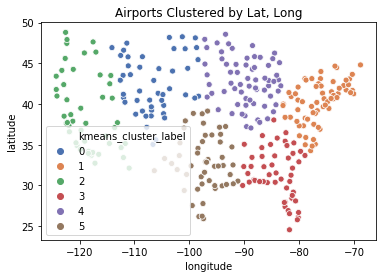

In [0]:
airport_lat_long['kmeans_cluster_label'] = KMeans(n_clusters=6, random_state=0).fit_predict(airport_lat_long[['latitude', 'longitude']])

sns.scatterplot(data=airport_lat_long, x='longitude', y='latitude', hue='kmeans_cluster_label', palette="deep")
plt.title("Airports Clustered by Lat, Long")
plt.show()

## DBSCAN
Using dbscan uses unsupervised density based clustering that does not require a pre-specified number of clusters. This algorithm can utilize proper geographic distances however it does not produce natural clusters and the central and eastern regions of the country stay grouped together

In [0]:
# https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
kms_per_radian = 6371.0088
epsilon = 225 / kms_per_radian
coords = airport_lat_long[['latitude', 'longitude']]
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
airport_lat_long['dbscan_cluster_label'] = cluster_labels
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 5

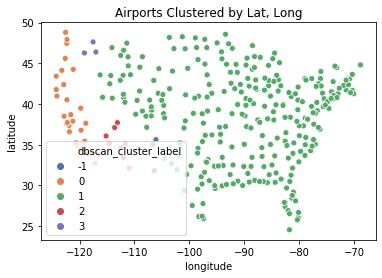

In [0]:
sns.scatterplot(data=airport_lat_long, x='longitude', y='latitude', hue='dbscan_cluster_label', palette="deep")
plt.title("Airports Clustered by Lat, Long")
plt.show()

In [0]:
def cluster_airports(data):
  origin_lat_long = data.select(f.col("origin").alias("airport_code"), f.col("origin_latitude").alias("latitude"), f.col("origin_longitude").alias("longitude")).distinct()
  dest_lat_long = data.select(f.col("dest").alias("airport_code"), f.col("dest_latitude").alias("latitude"), f.col("dest_longitude").alias("longitude")).distinct()
  airport_lat_long = origin_lat_long.unionByName(dest_lat_long).distinct().toPandas()
  
  # fit kmeans(6) to airport (lat,long)s and add labels to dataframe
  airport_lat_long['kmeans_cluster_label'] = KMeans(n_clusters=min(6, airport_lat_long.shape[0]), random_state=0).fit_predict(airport_lat_long[['latitude', 'longitude']])
  airport_regions = spark.createDataFrame(airport_lat_long[['airport_code', 'kmeans_cluster_label']])
  
  data = data.join(f.broadcast(airport_regions), f.col('ORIGIN') == f.col('airport_code')) \
    .withColumnRenamed('kmeans_cluster_label', 'origin_region') \
    .drop('airport_code')
  
  data = data.join(f.broadcast(airport_regions), f.col('DEST') == f.col('airport_code')) \
    .withColumnRenamed('kmeans_cluster_label', 'dest_region') \
    .drop('airport_code')
  return data

In [0]:
joined_features_w_airport_clusters = cluster_airports(joined_features_full)

joined_features_w_airport_clusters \
  .write \
  .mode('Overwrite') \
  .parquet(team_folder + "/joinedFeaturesFullClustered.parquet")

# Model

## Utility methods and metrics calculations for models

### Data splits
The following methods minimize data leakage between groups by ensuring each group of date and airport cluster are exclusive to one of train, val, and test splits.  
**Motivation**: prevent leakage across groups learning intraday events such as holiday rushes and/or extreme weather events affecting a region. Splitting on date alone, may cause unnecessarily high variance since annual holidays, such as Thanksgiving and Christmas, may not distribute across splits since there are only 4 years of data. By adding the region dimension, we increase the probability of holidays appropriately spreading across data splits while minimizing leakage of same-day weather events (e.g. blizzard in Chicago affects ORD and MDW).

In [0]:
def split_by_date_and_region(data, datecolumn='FL_DATE', region="origin_region", splits=[0.8,0.1,0.1], drop_date=True):
  def hashAndAssign(x, splits):
    hash_val = hash(x)
    perc = (hash_val % 1000) / 1000.0
    for i, split in enumerate(splits):
      if perc < split:
        return i
      perc -= split
    return i
  hash_and_assign_udf = f.udf(lambda x: hashAndAssign(x, splits), IntegerType())
  
  data = data.withColumn('data_group', hash_and_assign_udf(f.concat_ws('_',f.col(datecolumn),f.col(region))))
  if drop_date:
    data = data.drop(datecolumn)
  return data


def split_data_by_column(data, col_name="data_group"):
  train = data.filter(f.col(col_name) == 0).drop(col_name)
  valid = data.filter(f.col(col_name) == 1).drop(col_name)
  test = data.filter(f.col(col_name) == 2).drop(col_name)
  return train, valid, test

#### Subclass TrainingValidation Pipeline
`pyspark.ml.tuning.TrainValidationSplit` only accepts a train ratio and then randomly splits the data into train and validation data. As mentioned above, we wish to provide a custom sampling method and thus need to be able to pass in the predefined splits directly to the object instantiation

In [0]:
class CustomTrainValidationSplit(TrainValidationSplit):
  def __init__(self, estimator=None, estimatorParamMaps=None, 
               evaluator=None, parallelism=1, 
               collectSubModels=False, seed=None):
    super(CustomTrainValidationSplit, self).__init__(estimator=estimator, estimatorParamMaps=estimatorParamMaps, 
                                                     evaluator=evaluator, trainRatio=1, parallelism=parallelism, 
                                                     collectSubModels=collectSubModels, seed=seed)

  def _fit(self, dataset):
    est = self.getOrDefault(self.estimator)
    epm = self.getOrDefault(self.estimatorParamMaps)
    numModels = len(epm)
    eva = self.getOrDefault(self.evaluator)
    train, validation, _ = split_data_by_column(dataset, "data_group")
    train = train.cache()
    validation = validation.cache()

    subModels = None
    collectSubModelsParam = self.getCollectSubModels()
    if collectSubModelsParam:
        subModels = [None for i in range(numModels)]

    tasks = _parallelFitTasks(est, train, eva, validation, epm, collectSubModelsParam)
    pool = ThreadPool(processes=min(self.getParallelism(), numModels))
    metrics = [None] * numModels
    for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
        metrics[j] = metric
        print("****"*5)
        print({p.name: v for p, v in epm[j].items()})
        print(metrics[j])
        if collectSubModelsParam:
            subModels[j] = subModel

    train.unpersist()
    validation.unpersist()

    if eva.isLargerBetter():
        bestIndex = np.argmax(metrics)
    else:
        bestIndex = np.argmin(metrics)
    bestModel = est.fit(dataset, epm[bestIndex])
    print('Best Model: ', epm[bestIndex], 'Detailed Score {}'.format(matrix_metrics[bestIndex]))
    return self._copyValues(TrainValidationSplitModel(bestModel, metrics, subModels))


### Feature Transformation Pipelines

### Aggregated Features - Training Data Only
Aggregated summary features will only be calculated on training data in order to avoid data leakage.
Features will be aggregated on various levels as follows:
 - airports
   -

In [0]:
def categorical_feature_transformations_linear(onehot_cols, hash_cols):
  # hash encode categorical features with high cardinality
  hasher = FeatureHasher(num_features=400, inputCols=hash_cols, outputCol="hashFeatures")
  
  # one hot encode features with low cardinality
  onehotIndexers = []
  onehotInputs = []
  onehotFeatures = []
  for c in onehot_cols:
    indexer = StringIndexer(inputCol=c, outputCol=f"{c}_indexed")
    onehotIndexers.append(indexer)
    onehotInputs.append(indexer.getOutputCol())
    onehotFeatures.append(f"{c}_onehot")
  one_hot = OneHotEncoder(inputCols=onehotInputs, outputCols=onehotFeatures)
  
  # return output columns and transformation objects
  return ["hashFeatures"] + onehotFeatures, onehotIndexers + [one_hot, hasher]

def categorical_feature_transformations_trees(cols):
  indexers = []
  features = []
  # simply index all categories
  for c in cols:
    indexer = StringIndexer(inputCol=c, outputCol=f"{c}_indexed")
    indexers.append(indexer)
    features.append(f"{c}_indexed")
  
  # return output columns and transformation objects
  return features, indexers

def feature_transformation_pipeline(df, numerical_cols, onehot_cols, hash_cols, output, transform_categorical=True):
  pipeline_stages = []
  # normalize numerical columns
  num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numericalFeatures")
  normalizer = Normalizer(inputCol="numericalFeatures", outputCol="normFeatures")
  pipeline_stages.extend([num_assembler, normalizer])
  
  if transform_categorical: 
    # transform_categorical should be true if model requires vectorization of categorical feature, e.g. Linear Regression
    catFeatureCols, catStages = categorical_feature_transformations_linear(onehot_cols, hash_cols)
  else:
    # if tree based model, don't need to transform categorical features, just index
    catFeatureCols, catStages = categorical_feature_transformations_trees(onehot_cols + hash_cols)
    
  pipeline_stages.extend(catStages)
  
  # combine all feature transformations into a single feature vector
  assembler = VectorAssembler(inputCols=["normFeatures"] + catFeatureCols, outputCol="features")
  pipeline_stages.append(assembler)
  pipeline = Pipeline(stages=pipeline_stages)
  return pipeline

def full_model_pipeline():
  raise NotImplementedError


#function to convert df into consumable format for MLlib
def data_converter(df, numerical_cols, onehot_cols, hash_cols, output, transform_categorical=True, splits=[0.8,0.1,0.1], seed=0):
  pipe = feature_transformation_pipeline(df, numerical_cols, onehot_cols, hash_cols, output, transform_categorical=transform_categorical)
  
  tmp = df[numerical_cols + onehot_cols + hash_cols + [output, "FL_DATE"]]
  tmp = tmp.dropna()
  for c in onehot_cols + hash_cols:
    tmp = tmp.withColumn(c, f.col(c).cast(StringType()))
  data = split_by_date_and_region(tmp, 
                                  datecolumn="FL_DATE", 
                                  region="origin_region" if "origin_region" in tmp.columns else "origin",
                                  splits=splits)
  return data, pipe


def balance_classes(dataset, output_col, ratio=3.0, seed=2020):
  ones = dataset.where(f.col(output_col)==1).sample(True, ratio, seed=seed)
  zeroes = dataset.where(f.col(output_col)==0)
  train_final = zeroes.union(ones).orderBy(f.rand())
  return train_final

### Classification Utilities and Evaluations

In [0]:
#regression to classification with sigmoid activation
def sigmoid(logit):
  return 1 / (1 + math.exp(-logit))
sigmoid_udf = f.udf(sigmoid, FloatType())
      
def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None
extract_prob_udf = udf(lambda v: ith_(v, 1), DoubleType())

def format_predictions(predictions_df, output_col='DEP_DEL15'):
  #if regression based model, transform prediction with sigmoid and create label
  if not hasattr(predictions_df, 'probability'): 
    print("regression")
    predictions_df = predictions_df \
      .withColumn("label", (f.col(output_col) >= 15).cast(FloatType())) \
      .withColumn("delay_prob", sigmoid_udf(f.col("prediction") - 14.5))
  else:
    print("classification")
    predictions_df = predictions_df \
      .withColumn("label", (f.col(output_col)).cast(FloatType())) \
      .withColumn("delay_prob", extract_prob_udf("probability"))
  return predictions_df

from collections import namedtuple
ConfusionMatrix = namedtuple('ConfusionMatrix', ['TP', 'FP', 'TN', 'FN'])

def accuracy(confusion):
  return (confusion.TP + confusion.TN) / sum(confusion)

def accuracy_of_common_class_prediction(confusion):
  pos_class_prediction_accuracy = (confusion.TP + confusion.FN) / sum(confusion)
  return max(pos_class_prediction_accuracy, 1-pos_class_prediction_accuracy)

def precision(confusion):
  try:
    return (confusion.TP) / (confusion.TP + confusion.FP)
  except ZeroDivisionError:
    return float('nan')

def recall(confusion):
  return (confusion.TP) / (confusion.TP + confusion.FN)

def f1_score(confusion):
  prec = precision(confusion)
  rec = recall(confusion)
  return 2 * (prec * rec) / (prec + rec)

def categorize_prediction(pred, true):
  # [TP, FP, TN, FN]
  confusion = [0, 0, 0, 0]
  if pred == 1 and true == 1:
    confusion[0] = 1
  elif pred == 1 and true == 0:
    confusion[1] = 1
  elif pred == 0 and true == 0:
    confusion[2] = 1
  else:
    confusion[3] = 1
  return confusion

confusion_udf = f.udf(categorize_prediction, IntegerType())

def calc_metrics_at_thresh(df, prediction='probability', outcome='label', thresh=0.5, verbose=True):
  df = df.withColumn('prediction_at_thresh', (f.col(prediction) >= thresh).cast(IntegerType()))
  
  confusion = df.select(["prediction_at_thresh", outcome]).rdd \
    .map(lambda pred_truth: categorize_prediction(pred_truth[0], pred_truth[1])) \
    .reduce(lambda x, y: [sum(z) for z in zip(x, y)])
  confusion_matrix = ConfusionMatrix(*confusion)
  print(confusion_matrix)
  
  acc = accuracy(confusion_matrix)
  prec = precision(confusion_matrix)
  rec = recall(confusion_matrix)
  f1 = f1_score(confusion_matrix)
  
  if verbose:
    print("predicting frequent class would yield {:.4f} accuaracy".format(accuracy_of_common_class_prediction(confusion_matrix)))
    print(confusion_matrix)
    print("accuracy: {:.4f}".format(acc))
    print("precision: {:.4f}".format(prec))
    print("recall: {:.4f}".format(rec))
    print("f1: {:.4f}".format(f1))
  metrics = {'confusion_matrix': confusion_matrix, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
  return metrics

def confusion_by_thresh(df, prediction='probability', outcome='label'):
  _min, _max = df.select(f.min(f.col(prediction), f.max(f.col(prediction)))).collect()[0]
  
  confusion_matrices = df.select(prediction, outcome).rdd \
    .flatMap(lambda x: [(thresh, categorize_prediction(x[0]>=thresh, x[1])) for thresh in np.arange(_min, _max, 0.01)]) \
    .reduceByKey(lambda x, y: [sum(z) for z in zip(x, y)]) \
    .mapValues(lambda x: ConfusionMatrix(*x)) \
    .collect()
  
  confusion_df = pd.DataFrame(confusion_matrices, columns=["threshold", "confusion"])
  confusion_df['accuracy'] = confusion_df["confusion"].apply(lambda x: accuracy(x))
  confusion_df['precision'] = confusion_df["confusion"].apply(lambda x: precision(x))
  confusion_df['recall'] = confusion_df["confusion"].apply(lambda x: recall(x))
  confusion_df['f1'] = confusion_df["confusion"].apply(lambda x: f1_score(x))
  return confusion_df

def plot_pr_curve(confusion_by_thresh):
  prec_rec = confusion_by_thresh[['precision', 'recall']].dropna().sort_values('recall')
  sns.lineplot(data=prec_rec, x='recall', y='precision')
  plt.title('Precision-Recall')
  plt.show()

def plot_predictions_by_label(predictions, prediction='probability', outcome='label', fractions={0: 0.005, 1: 0.001}):
  sampled = predictions.sampleBy(outcome, fractions=fractions, seed=0).select(probability, outcome).toPandas()
  sns.distplot(sampled[prediction][sampled[outcome]==0], label="Label=0")
  sns.distplot(sampled[prediction][sampled[outcome]==1], label="Label=1")
  plt.xlabel("predictions")
  plt.legend()
  plt.show()

## Baseline model
Trained on 2015 3 month data for only ORD and ATL

In [0]:
joined = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesSmall.parquet")

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2158640876511469> in <module> 
 ----> 1 joined = spark . read . option ( "header" , "true" ) . parquet ( team_folder + "/joinedFeaturesSmall.parquet" ) 

 NameError : name 'team_folder' is not defined

In [0]:
model_type = DecisionTreeClassifier
transform_categorical = model_type in [LinearRegression, LogisticRegression]

#baseline model
numerical_cols = ['wind_speed', 'wind_speed_minus_1', 'wind_speed_minus_2', 'diff_to_max_wind',
                  'visibility', 'visibility_minus_1', 'visibility_minus_2',
                  'ceiling', 'ceiling_minus_1', 'ceiling_minus_2',
                  'snow_depth', 'snow_depth_minus_1', 'snow_depth_minus_2',
                  'precip_period', 'precip_depth', 'max_precip_period', 'max_precip_depth',
                  'pressure', 'pressure_minus_1', 'pressure_minus_2', 
                  'temperature', 'dew_temperature', 'latitude', 'longitude',
                  'elevation', 'tail_num_arrival_to_next_departure_delta', 'distance_group']
onehot_cols = ['origin', 'dest', 'op_unique_carrier', 'tail_num_from',] # only one value for small ord and atl dataset ['snow_condition', 'visibility_variability']
hash_cols = ['tail_num']

data, pipe = data_converter(joined, numerical_cols, onehot_cols, hash_cols, output='DEP_DEL15', 
                                    transform_categorical=transform_categorical)
train, valid, test = split_data_by_column(data, )

train.cache()
valid.cache()
test.cache()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-667068395491595> in <module> 
 14 hash_cols = [ 'tail_num' ] 
 15 
 ---> 16 data, pipe = data_converter(joined, numerical_cols, onehot_cols, hash_cols, output='DEP_DEL15', 
 17 transform_categorical=transform_categorical)
 18 train , valid , test = split_data_by_column ( data , ) 

 NameError : name 'joined' is not defined

In [0]:
#train and test model
model = Pipeline(stages = [pipe, model_type(featuresCol= 'features', labelCol = 'DEP_DEL15', maxDepth=15)])

print("fitting model")
model = model.fit(train)

print("calculating predictions")
predictions = model.transform(valid)
predictions = format_predictions(predictions)

#calculate classification metrics
metrics = BinaryClassificationMetrics(predictions.select(["delay_prob", "label"]).rdd)
print("PR AUC: {}".format(metrics.areaUnderPR))
print("ROC AUC: {}".format(metrics.areaUnderROC))

calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome='label', thresh=0.5, verbose=True)

fitting model
calculating predictions
classification
PR AUC: 0.47265086088936314
ROC AUC: 0.7006221127888124
predicting frequent class would yield 0.7616 accuaracy
ConfusionMatrix(TP=1499, FP=915, TN=11217, FN=2299)
accuracy: 0.7982
precision: 0.6210
recall: 0.3947
f1: 0.4826
Out[63]: {'confusion_matrix': ConfusionMatrix(TP=1499, FP=915, TN=11217, FN=2299),
 'accuracy': 0.7982423101067169,
 'precision': 0.6209610604805302,
 'recall': 0.394681411269089,
 'f1': 0.48261429491307145}

## TrainVal Tuning on Full Dataset

In [0]:
full_dataset = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesFullClustered.parquet")

In [0]:
model_type = GBTClassifier
transform_categorical = model_type in [LinearRegression, LogisticRegression]

#baseline model
numerical_cols = ['origin_wind_speed', 'origin_wind_speed_minus_1', 'origin_wind_speed_minus_2', 'origin_diff_to_max_wind',
                  'origin_visibility', 'origin_visibility_minus_1', 'origin_visibility_minus_2',
                  'origin_ceiling', 'origin_ceiling_minus_1', 'origin_ceiling_minus_2',
                  'origin_snow_depth', 'origin_snow_depth_minus_1', 'origin_snow_depth_minus_2',
                  'origin_precip_period', 'origin_precip_depth', 'origin_max_precip_period', 'origin_max_precip_depth',
                  'origin_pressure', 'origin_pressure_minus_1', 'origin_pressure_minus_2', 
                  'origin_temperature', 'origin_dew_temperature', 'origin_elevation', 
                  
                  'dest_snow_depth', 'dest_snow_depth_minus_1', 'dest_snow_depth_minus_2',
                  'dest_precip_period', 'dest_precip_depth', 'dest_max_precip_period', 'dest_max_precip_depth',
                  'dest_pressure', 'dest_pressure_minus_1', 'dest_pressure_minus_2', 
                  
                  'tail_num_arrival_to_next_departure_delta', 'distance_group', 'local_hour']
onehot_cols = ['origin_region', 'dest_region', 'op_unique_carrier', 'quarter', 'month', 'day_of_week',
               'origin_snow_condition', 'origin_visibility_variability',]
hash_cols = []#['tail_num']

data, feature_pipe = data_converter(full_dataset, numerical_cols, onehot_cols, hash_cols, output='DEP_DEL15',
                                    transform_categorical=transform_categorical, splits=[0.9, 0.05, 0.05])

In [0]:
numerical_cols[35]

Out[14]: 'hour'

In [0]:
model_type = GBTClassifier
model = model_type(featuresCol= 'features', labelCol='label')
full_pipe = Pipeline(stages = [feature_pipe, model])

paramGrid = ParamGridBuilder()\
    .addGrid(model.maxDepth, [10]) \
    .addGrid(model.maxIter, [10, 25, 100])\
    .addGrid(model.minInfoGain, [0.0, 0.01, 0.05])\
    .build()

tvs_gbt = CustomTrainValidationSplit(estimator=full_pipe,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                                   parallelism=1)

In [0]:
tvs_gbt_model = tvs_gbt.fit(data.withColumnRenamed('DEP_DEL15', 'label'))

In [0]:
_, valid, _ = split_data_by_column(data)

print("calculating predictions")
predictions = tvs_gbt_model.transform(valid.withColumnRenamed('DEP_DEL15', 'label').cache())
predictions = format_predictions(predictions, output_col='label')

#calculate classification metrics
metrics = BinaryClassificationMetrics(predictions.select(["delay_prob", "label"]).rdd)
print("PR AUC: {}".format(metrics.areaUnderPR))
print("ROC AUC: {}".format(metrics.areaUnderROC))

calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome='label', thresh=0.25, verbose=True)

java.lang.RuntimeException: abort: DriverClient destroyed
	at com.databricks.backend.daemon.driver.DriverClient.$anonfun$poll$3(DriverClient.scala:381)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at com.databricks.threading.NamedExecutor$$anon$2.$anonfun$run$1(NamedExecutor.scala:345)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:240)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:235)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:232)
	at com.databricks.threading.NamedExecutor.withAttributionContext(NamedExecutor.scala:275)
	at com.databricks.threading.NamedExecutor$$anon$2.run(NamedExecutor.scala:345)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
tvs_gbt_model.save(team_folder+"/temp_model2")

In [0]:
calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome='label', thresh=0.45, verbose=True)

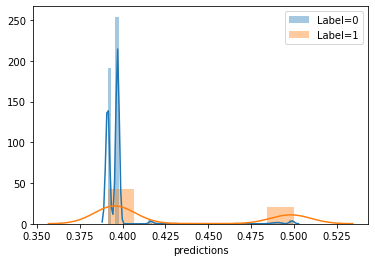

In [0]:
plot_predictions_by_label(predictions, fractions={0: 0.005, 1: 0.01}, prediction='delay_prob', outcome='label')

In [0]:
train, valid, _ = split_data_by_column(data)
persistedModel = PipelineModel.load(team_folder + "/temp_model")
predictions = persistedModel.transform(valid.withColumnRenamed('DEP_DEL15', 'label').cache())
predictions = format_predictions(predictions, output_col='label')

classification

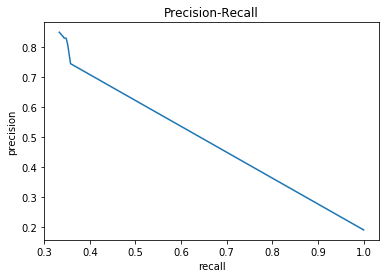

In [0]:
confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
plot_pr_curve(confusions)

In [0]:
confusions.sort_values('threshold').iloc[30:60]

Out[27]:

threshold 
 confusion 
 accuracy 
 precision 
 recall 
 f1 
 
 
 
 
 63 
 0.30 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 24 
 0.31 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 82 
 0.32 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 46 
 0.33 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 3 
 0.34 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 64 
 0.35 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 94 
 0.36 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 58 
 0.37 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 17 
 0.38 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 76 
 0.39 
 (334512, 1416877, 0, 0) 
 0.190998 
 0.190998 
 1.000000 
 0.320736 
 
 
 39 
 0.40 
 (119647, 41045, 1375832, 214865) 
 0.853882 
 0.744573 
 0.357676 
 0.483223 
 
 
 95 
 0.41 
 (119647, 41045, 1375832, 214865) 
 0.853882 
 0.744573 
 0.357676 
 0.483223 
 
 
 29 
 0.42 
 (117537, 27745, 1389132, 216975) 
 0.860271 
 0.809027 
 0.351369 
 0.489948 
 
 
 86 
 0.43 
 (116625, 24644, 1392233, 217887) 
 0.861521 
 0.825553 
 0.348642 
 0.490247 
 
 
 49 
 0.44 
 (116427, 23996, 1392881, 218085) 
 0.861778 
 0.829116 
 0.348050 
 0.490286 
 
 
 8 
 0.45 
 (114882, 23482, 1393395, 219630) 
 0.861189 
 0.830288 
 0.343432 
 0.485886 
 
 
 69 
 0.46 
 (114513, 23101, 1393776, 219999) 
 0.861196 
 0.832132 
 0.342329 
 0.485095 
 
 
 30 
 0.47 
 (114210, 22534, 1394343, 220302) 
 0.861347 
 0.835210 
 0.341423 
 0.484705 
 
 
 60 
 0.48 
 (113684, 22122, 1394755, 220828) 
 0.861282 
 0.837106 
 0.339850 
 0.483435 
 
 
 21 
 0.49 
 (111410, 19795, 1397082, 223102) 
 0.861312 
 0.849129 
 0.333052 
 0.478445 
 
 
 78 
 0.50 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 42 
 0.51 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 98 
 0.52 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 61 
 0.53 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 22 
 0.54 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 79 
 0.55 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 43 
 0.56 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 99 
 0.57 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 4 
 0.58 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN 
 
 
 65 
 0.59 
 (0, 0, 1416877, 334512) 
 0.809002 
 NaN 
 0.000000 
 NaN

In [0]:
model_type = RandomForestClassifier
model = model_type(featuresCol= 'features', labelCol='label')
full_pipe = Pipeline(stages = [feature_pipe, model])

paramGrid = ParamGridBuilder()\
    .addGrid(model.maxDepth, [15]) \
    .addGrid(model.numTrees, [500]) \
    .addGrid(model.minInfoGain, [0.01]) \
    .addGrid(model.subsamplingRate, [0.5, 0.8]) \
    .build()

tvs_rf = CustomTrainValidationSplit(estimator=full_pipe,
                                 estimatorParamMaps=paramGrid,
                                 evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),
                                 parallelism=1)

In [0]:
tvs_rf_model = tvs_rf.fit(data.withColumnRenamed('DEP_DEL15', 'label'))

In [0]:
_, valid, _ = split_data_by_column(data)

print("calculating predictions")
predictions = tvs_rf_model.transform(valid)
predictions = format_predictions(predictions)

#calculate classification metrics
metrics = BinaryClassificationMetrics(predictions.select(["delay_prob", "label"]).rdd)
print("PR AUC: {}".format(metrics.areaUnderPR))
print("ROC AUC: {}".format(metrics.areaUnderROC))

calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome='label', thresh=0.5, verbose=True)

calculating predictions

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3450569410557368> in <module> 
 2 
 3 print ( "calculating predictions" ) 
 ----> 4 predictions = tvs_rf_model . transform ( valid ) 
 5 predictions = format_predictions ( predictions ) 
 6 

 NameError : name 'tvs_rf_model' is not defined

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))
  
ExtractFeatureImp(tvs_rf_model.stages[-1].featureImportances, tvs_gbt_model.stages[0].transform(train), "features")

Out[15]:

idx 
 name 
 vals 
 score 
 
 
 
 
 33 
 33 
 normFeatures_33 
 NaN 
 8.916697e-01 
 
 
 35 
 35 
 normFeatures_35 
 NaN 
 6.835987e-02 
 
 
 13 
 13 
 normFeatures_13 
 NaN 
 8.653600e-03 
 
 
 15 
 15 
 normFeatures_15 
 NaN 
 7.807999e-03 
 
 
 26 
 26 
 normFeatures_26 
 NaN 
 5.034322e-03 
 
 
 28 
 28 
 normFeatures_28 
 NaN 
 3.663563e-03 
 
 
 23 
 23 
 normFeatures_23 
 NaN 
 2.995213e-03 
 
 
 34 
 34 
 normFeatures_34 
 NaN 
 2.908323e-03 
 
 
 4 
 4 
 normFeatures_4 
 NaN 
 2.836585e-03 
 
 
 10 
 10 
 normFeatures_10 
 NaN 
 1.783479e-03 
 
 
 0 
 0 
 normFeatures_0 
 NaN 
 1.014901e-03 
 
 
 17 
 17 
 normFeatures_17 
 NaN 
 9.310780e-04 
 
 
 30 
 30 
 normFeatures_30 
 NaN 
 4.835790e-04 
 
 
 7 
 7 
 normFeatures_7 
 NaN 
 2.905731e-04 
 
 
 20 
 20 
 normFeatures_20 
 NaN 
 2.857451e-04 
 
 
 21 
 21 
 normFeatures_21 
 NaN 
 2.337698e-04 
 
 
 8 
 8 
 normFeatures_8 
 NaN 
 2.252167e-04 
 
 
 9 
 9 
 normFeatures_9 
 NaN 
 2.193797e-04 
 
 
 29 
 29 
 normFeatures_29 
 NaN 
 1.921410e-04 
 
 
 14 
 14 
 normFeatures_14 
 NaN 
 1.696190e-04 
 
 
 16 
 16 
 normFeatures_16 
 NaN 
 1.119789e-04 
 
 
 3 
 3 
 normFeatures_3 
 NaN 
 7.339570e-05 
 
 
 25 
 25 
 normFeatures_25 
 NaN 
 2.340611e-05 
 
 
 6 
 6 
 normFeatures_6 
 NaN 
 9.664685e-06 
 
 
 24 
 24 
 normFeatures_24 
 NaN 
 7.042790e-06 
 
 
 27 
 27 
 normFeatures_27 
 NaN 
 4.074050e-06 
 
 
 5 
 5 
 normFeatures_5 
 NaN 
 3.240123e-06 
 
 
 38 
 38 
 op_unique_carrier_indexed 
 [WN, AA, DL, OO, UA, EV, B6, MQ, NK, YX, AS, 9... 
 2.347392e-06 
 
 
 22 
 22 
 normFeatures_22 
 NaN 
 1.847566e-06 
 
 
 40 
 40 
 month_indexed 
 [7, 6, 8, 5, 4, 3, 12, 10, 1, 9, 11, 2] 
 9.491727e-07 
 
 
 12 
 12 
 normFeatures_12 
 NaN 
 7.431137e-07 
 
 
 36 
 36 
 origin_region_indexed 
 [0, 5, 4, 3, 1, 2] 
 7.280948e-07 
 
 
 1 
 1 
 normFeatures_1 
 NaN 
 4.583029e-07 
 
 
 31 
 31 
 normFeatures_31 
 NaN 
 3.389657e-07 
 
 
 41 
 41 
 day_of_week_indexed 
 [5, 4, 1, 2, 3, 7, 6] 
 3.366644e-07 
 
 
 18 
 18 
 normFeatures_18 
 NaN 
 2.173078e-07 
 
 
 32 
 32 
 normFeatures_32 
 NaN 
 1.709299e-07 
 
 
 19 
 19 
 normFeatures_19 
 NaN 
 1.677658e-07 
 
 
 37 
 37 
 dest_region_indexed 
 [0, 3, 5, 4, 1, 2] 
 1.223790e-07 
 
 
 39 
 39 
 quarter_indexed 
 [3, 2, 4, 1] 
 3.771239e-08 
 
 
 2 
 2 
 normFeatures_2 
 NaN 
 2.589883e-08 
 
 
 11 
 11 
 normFeatures_11 
 NaN 
 1.029886e-08 
 
 
 42 
 42 
 origin_snow_condition_indexed 
 [-1, 9, 3] 
 0.000000e+00 
 
 
 43 
 43 
 origin_visibility_variability_indexed 
 [N, V, 9] 
 0.000000e+00

In [0]:
tvs_rf_model.validationMetrics

In [0]:
# ORD -> busyness value

### airport representation at time t
# busyness = number of departing flights scheduled for t
# variety of outbound destinations
# number of carriers that fly out
# recent_delay = proportion of flights delayed as of t-2
# ...
